<a href="https://colab.research.google.com/github/MarialuizaLeao/2021-1-exercicio-revisao-refatoracao/blob/main/tp1Algoritmos2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabalho Prático 1 - Geometria computacional**

**Grupo:**

> Isabella Vignoli Gonçalves - 2020006655

> Maria Luiza Leão Silva - 2020100953

##Imports

In [ ]:
!pip install bintrees
from random import randint
import matplotlib.pyplot as plt
import bintrees
import pandas as pd
import numpy as np
import copy as cp
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Funções para o calculo das primitivas

Foram implementadas as três primitivas vistas em sala que foram utilizadas posteriormente nos algoritmos de geometria computacional.

In [ ]:
# Determina se um ponto está à direita ou à esquerda de determinado seguimento( postos p0 e p1), caso retorne 0 temos que o ponto é colinear ao segmento 
def DirecaoRota(p0, p1, p2):
  produtoVetorial = ((p1[0] - p0[0]) * (p2[1] - p0[1]) - (p2[0] - p0[0]) * (p1[1] - p0[1]))  # Calculo do produto vetorial obtido pelos pontos p0, p1 e p2
  if produtoVetorial == 0: 
    return 0  # colinear
  else:
    if produtoVetorial < 0:
      return -1  # anti-horario
    else:
      return 1  # horario


def ComparacaoAnguloPolar(p0, p1, p2): 
  direcao = DirecaoRota(p0, p1, p2)
  if direcao != 0:  # Se os dois pontos não são colineares, informamos a direção
    return direcao
  else:  # Se são colineares, retornamos 2
    return 2

# Classe para representar um segmento
class Segmento:
  def __init__(self, inicio = None, fim = None, IdEnvoltoria = None):
    self.inicio = inicio  # Tupla x e y do ponto inical do segmento
    self.fim = fim  # Tupla x e y do ponto inical do segmento
    self.IdEnvoltoria = IdEnvoltoria  # Inteiro para identificar de qual envotoria veio aquele segmento, utilizado principalmente para ignorar a interseção entre segmentos da mesma envoltoria(poligono convexo)


# Determina se o ponto p2 faz parte da reta p0p1
def PontoPertenceAReta(p0, p1, p2):
  if(p2[0] <= max(p0[0], p2[0]) and p2[0] >= min(p0[0], p2[0]) and p2[1] <= max(p0[1], p2[1]) and p2[1] >= min(p0[1], p2[1])):
    return True
  return False

# Determinar se dois segmentos, s1 e s2, se inteceptam
def TemIntersecao(s1, s2):

  if(s1.IdEnvoltoria == s2.IdEnvoltoria):  # Se os dois segmentos pertencem a mesma envoltoria, retornamos que não se interceptam
    return False

  orientacao1 = DirecaoRota(s1.inicio, s1.fim, s2.inicio)  # Direção do ponto inical do segundo segmento em relação ao primeiro segmento
  orientacao2 = DirecaoRota(s1.inicio, s1.fim, s2.fim)  # Direção do ponto final do segundo segmento em relação ao primeiro segmento
  orientacao3 = DirecaoRota(s2.inicio, s2.fim, s1.inicio)  # Direção do ponto inical do primeiro segmento em relação ao segundo segmento
  orientacao4 = DirecaoRota(s2.inicio, s2.fim, s1.fim)  # Direção do ponto final do primeiro segmento em relação ao segundo segmento

  # Caso geral
  if(orientacao1 != orientacao2 and orientacao3 != orientacao4):
    return True

  # Casos especiais
  if(orientacao1 == 0 and PontoPertenceAReta(s1.inicio, s2.inicio, s1.fim)):  # p1, p2 e p3 são colineares e p3 pertence ao segmento p1p2
    return True
  if(orientacao2 == 0 and PontoPertenceAReta(s1.inicio, s2.fim, s1.fim)):  # p1, p2 e p4 são colineares e p4 pertence ao segmento p1p2
    return True
  if(orientacao3 == 0 and PontoPertenceAReta(s2.inicio, s1.inicio, s2.fim)):  # p3, p4 e p1 são colineares e p1 pertence ao segmento p3p4
    return True
  if(orientacao4 == 0 and PontoPertenceAReta(s2.inicio, s1.fim, s2.fim)):  # p3 p4 e p2 são colineares e p2 pertence ao segmento p3p4
    return True

  return False

## Parte 1: encontrar a envoltória convexa dos pontos 

> O algoritmo de envoltória convexa implementado foi o algoritmo de Graham que é o algoritmo com qual o grupo se sentia mais confortável para implementar. Abaixo, temos as funções auxiliares utilizadas para o tratamento dos pontos antes das operações do algoritmo em si. Temos que encontrar um ponto âncora, isso é, o ponto com menor coordenada y, ou menor x em caso de empate, que sera o ponto inicial da nossa envoltória.


> Uma vez que determinamos o ponto âncora, iremos oredenar todos os demais pontos em ordem crescente em relação ao ângulo polar formado entre ele e a âncora. Para essa ordenação, implementamos um QuickSort recursivo, que recebe o ponto âncora e a lista de demais pontos e vai particionando essa lista em menores, maiores e igual ao pivô que é escolhido aleatoriamente.


> Por ultimo, eliminamos os pontos que possuem o mesmo ângulo polar com a âncora. Deletamos os pontos mais próximos da âncora, deixando somente aqueles mais distantes, uma vez que a reta formada por ele e a âncora erá conter os pontos que eram mais próximos.


> O algoritmo tem complexidade O(n * log n). Encontrar a âncora, excluir pontos com o mesmo angulo e processar ponto a ponto adicionando na pilha têm custo O(n). Já ordenar os pontos é O(n * log n), caso médio do QuickSort.



In [ ]:
# Encontra p ponto Âncora na lista de pontos Q
def EncontrarAncora(Q):

  ancoraY = Q[0][1]  # Coordenada y da âncora
  indiceAncora = 0  # Indice da âncora na lista Q

  for i in range(1, len(Q)):  # Para cada ponto da lista
    y = Q[i][1]
    if((y < ancoraY) or (y == ancoraY and Q[i][0] < Q[indiceAncora][0])):  # Se encontramos um ponto com coordenada y menor do que da âncora altual, ou com mesmo y mas com x menor 
      ancoraY = Q[i][1]
      indiceAncora = i

  return indiceAncora

# QuickSort para os pontos de acordo com o ângulo polar formado com a âncora(p0)
def QuickSortPontos(p0, Q):

  n = len(Q)
  if (n < 2): # Se a lista possui menos que dois elementos, retornamos Q
    return Q

  menor, igual, maior = [], [], []

  pivo = Q[randint(0, n - 1)]  # Escolhe um elemento aleatorio da lista para ser o pivô

  for pi in Q:  # Para cada ponto na lista
    comp = ComparacaoAnguloPolar(p0, pi, pivo)
    if comp == 1:  # Pivô está a direita do segmento p0pi
      menor.append(pi)
    else:
      if comp == -1:  # Pivô está a enquerda do segmento p0pi
        maior.append(pi)
      else:
        if comp == 2: # Pivô é colinear segmento p0pi
          igual.append(pi)

  return QuickSortPontos(p0, menor) + igual + QuickSortPontos(p0, maior)

# Retorna a distância cartesiana entre dois pontos p1 e p2
def DistanciaDoisPontos(p1, p2):
  return ((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)


# Deleta os pontos com mesmo ângulo polar que estão mais perto da âncora
def DeletarPontosComMesmoAngulo(p0, Q):

  n = len(Q)
  for i in range(0, len(Q)):  # Para cada elemento da lista
    while((i < len(Q) - 1) and (DirecaoRota(p0, Q[i], Q[i + 1]) == 0)):   # Quando dois pontos consecutivos (por causa da ordenacao do quickSort) da lista ordenada forem colineares com a âncora
      if ((DistanciaDoisPontos(p0, Q[i + 1])) >= (DistanciaDoisPontos(p0, Q[i]))):  # Mantemos somente o ponto mais distante de p0
        del Q[i]
      else:
        del Q[i+1]

  return Q

# Recebe uma lista de pontos e realiza o tratamento utilizando as funções acima
def TratamentoPontos(Q):

  indiceAncora = EncontrarAncora(Q)  # Indice do ponto com menor y
  ancora = Q[indiceAncora]  # Ponto âncora

  del Q[indiceAncora]  # Retirar a âncora da lista

  QSemAncoraOrdenado = QuickSortPontos(ancora, Q)  # Lista sem a âncora ordenada

  QSemAncoraOrdenado = DeletarPontosComMesmoAngulo(ancora, QSemAncoraOrdenado)  # Lista sem a âncora ordenada sem repetição de ângulo polar

  return indiceAncora, ancora, QSemAncoraOrdenado


In [ ]:
def GrahamScan(Q): 

  indiceAncora, ancora, QSemAncoraOrdenado = TratamentoPontos(Q)  # Recebe o indice da ancora, a ancora e todos os pontos tratados
  if(len(QSemAncoraOrdenado) <= 2):
    return [ancora] + QSemAncoraOrdenado
  pilha = []  # Inicializa a pilha vazia
  pilha.append(ancora)  # Adiciona na pilha a ancora
  pilha.append(QSemAncoraOrdenado[0])  # Adiciona o primeiro ponto na pilha
  pilha.append(QSemAncoraOrdenado[1])  # Adiciona o segundo ponto na pilha

  for i in range(2, len(QSemAncoraOrdenado)):  # Para cada ponto ordenado
    while((len(pilha) > 1) and (DirecaoRota(pilha[-2], pilha[-1], QSemAncoraOrdenado[i]) != 1)):  # Enquanto temos giros para direita
      pilha.pop()  # Retiramos o elemento do topo da pilha
    pilha.append(QSemAncoraOrdenado[i])  # Quando temos um giro para esqueda, adicionamos esse ponto na pilha

  return pilha

## Parte 2: verificar se há interseção entre as envoltórias

> Para encontrar possiveis interseções entre as envoltórias, foi implementado o algoritmo any-segment-intersec visto em aula, contudo, com algumas mudanças. Um dos primeiros problemas percebidos pelo grupo foi que em uma envoltória convexa, as suas retas se interceptam mas essas interseçõees são permitidas. O que a gente precisa verificar é se a interseção ocorre entre duas retas que pertencem a envotórias diferentes.

> Tendo isso em mente, optamos por criar uma classe para o objeto segmento, a classe mostrada na parte de cálculo das primitivas. Um segmento é composto por dois pontos(inicio, fim) e o id da envoltória da qual esse segmento faz parte. Assim, somos capazes de comparar se as retas fazem parte da mesma envoltória e, em caso afirmativo, não realizamos o calculo da primitiva de intereção entre elas.

> Ademais, outro problema encontrado foi que, na envoltória, podems ter segmentos com o mesmo ponto inicial, isso é, na hora de ordenar os eventos, teremos dois eventos iguais mas que pertencem a retas diferentes, o que não era um caso tratado no algoritmo visto. Para soluciona-lo, realizamos um pré processamento nos segmentos, durante a ordenação do QuickSort, para alterar o y dos eventos "repetidos" para que na hora da comparação eles sejam vistos como eventos distintos mas que o valor ainda permaneça parecido o suficiente para não prejudicar o calculo da interseção.


> Já em questão da estrutura de dados utilizada, optamos pelo uso de uma árvore AVL da biblioteca bintrees. Um dos principais motivos de optar por uma arvore balanciada de pesquisa é que assim conseguimos inserir, retirar e procurar os segmentos na ordem correta, e tudo isso com complexidade O(log n).

> Temos que complexidade final do algoritmo é O(n * log n) devido ao uso do QuickSort para ordenar os eventos.



In [ ]:
# Devemos verificar se há interseções nas retas de conjuntos diferentes

# Recebe os pontos de uma envoltoria e retorna os segmentos que formam essa envoltoria
def ContrutorSegEnvoltoria(envoltoria, IdEnvoltoria):

  segmentos = []
  for i in range(0, len(envoltoria) - 1):  # Para cada ponto da envoltoria
    p1 = envoltoria[i]
    p2 = envoltoria[i+1]
    if(p1[0] < p2[0]):  # Se o x de pi for menor que o x de p(i + 1), pi eh o inicio do segmento
      segmentos.append(Segmento(envoltoria[i], envoltoria[i+1],IdEnvoltoria))
    else:  # Caso contrario, pi eh o ponto fim do segmento
      segmentos.append(Segmento(envoltoria[i+1], envoltoria[i],IdEnvoltoria))
  # Para o ultimo ponto da envoltoria, devemos conectalo com o ponto inicial(ancora)
  if(envoltoria[len(envoltoria) - 1][0] < envoltoria[0][0]):  # Caso o x do ultimo ponto for menor que o x da ancora, temos que ele eh o inicio do segmento
    segmentos.append(Segmento(envoltoria[len(envoltoria) - 1], envoltoria[0], IdEnvoltoria))
  else:  # Caso contrario, ele eh o ponto fim do segmento
    segmentos.append(Segmento(envoltoria[0], envoltoria[len(envoltoria) - 1], IdEnvoltoria))

  return segmentos

# Recebe uma lista com todos os eventos, a lista de segmentos da primeira envoltoria e a lista de segmentos da segunda envoltoria    
def QuickSortEventos(listaEventos, SegE1, SegE2):

  n = len(listaEventos) # Se a lista possui menos que dois elementos, retornamos Q
  if (n < 2):
    return listaEventos

  menor, igual, maior = [], [], []

  pivo = listaEventos[randint(0, n - 1)]  # Escolhe um elemento aleatorio da lista para ser o pivô

  if pivo[3] == 0:  # Se o pivo pertence a primeira envoltoria
    yFinalPivo = SegE1[pivo[2]].fim[1]  # Encontramos o y do ponto final do segmento do qual o pivo faz parte
  else:  # Se o pivo pertence a segunda envoltoria
    yFinalPivo = SegE2[pivo[2]].fim[1]  # # Encontramos o y do ponto final do segmento do qual o pivo faz parte

  for pi in listaEventos:  # Para cada evento
    if pi[0][0] < pivo[0][0]:  # Caso o pivo tenha x maior que o de pi
      menor.append(pi)
    else:
      if pi[0][0] > pivo[0][0]:  # Caso o pivo tenha x menor que o de pi
        maior.append(pi)
      else:
        if pi[1] != pivo[1]:  # Caso sejam tipos de eventos distintos
          if pi[1] == 0:  # Se pi eh um evento de inicio
            menor.append(pi)
          else:  # Se pi eh um evento de fim
            maior.append(pi)
        else:  # Caso sejam tipo de eventos iguais
          if pi[0][1] < pivo[0][1]:  # Caso o pivo tenha y maior que o de pi
            menor.append(pi)
          else:
            if pi[0][1] > pivo[0][1]:  # Caso o pivo tenha y menor que o de pi
              maior.append(pi)
            else:
              if pi[3] == 0:  # Se pi pertence a primeira envoltoria
                if SegE1[pi[2]].fim[1] > yFinalPivo:  # Se o ponto final do segmento do qual pi faz parte tem y maior do que o y do ponto final do segmento do qual o pivo faz parte
                  maior.append( ( (pi[0][0], pi[0][1] + 0.0000001), pi[1], pi[2], pi[3]))  # Somamos o ruido
                else:
                  if SegE1[pi[2]].fim[1] < yFinalPivo:  # Se o ponto final do segmento do qual pi faz parte tem y menor do que o y do ponto final do segmento do qual o pivo faz parte
                    menor.append(( (pi[0][0], pi[0][1] - 0.0000001), pi[1], pi[2], pi[3]))  # Subtraimos o ruido
                  else:  # Se sao iguais, temos o mesmo evento
                    igual.append(pi)
              else:  # Se pi pertence a segunda envoltoria
                if SegE2[pi[2]].fim[1] > yFinalPivo:  # Se o ponto final do segmento do qual pi faz parte tem y maior do que o y do ponto final do segmento do qual o pivo faz parte
                  maior.append(( (pi[0][0], pi[0][1] + 0.0000001), pi[1], pi[2], pi[3]))  # Somamos o ruido
                else:
                  if SegE2[pi[2]].fim[1] < yFinalPivo:  # Se o ponto final do segmento do qual pi faz parte tem y menor do que o y do ponto final do segmento do qual o pivo faz parte
                    menor.append(( (pi[0][0], pi[0][1] - 0.0000001), pi[1], pi[2], pi[3]))  # Subtraimos o ruido
                  else:
                    igual.append(pi)  # Se sao iguais, temos o mesmo evento

  return QuickSortEventos(menor, SegE1, SegE2) + igual + QuickSortEventos(maior, SegE1, SegE2)

# Recebe duas listas de segmentos e retorna um lista com os eventos das duas ordenadas
def OrdenacaoEventos(SegE1, SegE2):

  listaEventosE1 = []
  listaEventosE2 = []

  # elemento da lista de eventos representa (ponto, inicio/fim, posicao na lista de segmentos, id da envoltoria da qual faz parte)

  i = 0
  for seg in SegE1:  # Para cada segmento da primeira envoltoria
    listaEventosE1.append((seg.inicio, 0, i, seg.IdEnvoltoria))  # Adicionamos seu evento de inicio
    listaEventosE1.append((seg.fim, 1, i, seg.IdEnvoltoria))  # Adicionamos seu envento de fim
    i += 1

  i = 0
  for seg in SegE2:  # Para cada segmento da segunda envoltoria
    listaEventosE2.append((seg.inicio, 0, i, seg.IdEnvoltoria))  # Adicionamos seu evento de inicio
    listaEventosE2.append((seg.fim, 1, i, seg.IdEnvoltoria))  # Adicionamos seu evento de fim
    i += 1

  listaEventos = listaEventosE1 + listaEventosE2  # Concatenamos as duas listas de eventos

  listaEventosOrdenada = QuickSortEventos(listaEventos, SegE1, SegE2)  # Ordenamos os eventos

  return listaEventosOrdenada

#Encontra o segmento que corresponde a esse evento
def EncontraSegmento(evento, seg1, seg2):
  if evento[3] == 0:  # Se eh um evento da primeira envoltoria
    return seg1[evento[2]]
  else:  # Se eh um evento da segunda envoltoria
    return seg2[evento[2]]

#  Retorna se o no da arvore com essa chave possui um sucessor
def EstaAcima(T, chave, tipo):

  if tipo == 0:  # Se for um ponto do tipo inicio
    try:  # Tentamos encontrar a chave do sucessor desse no
      T.succ_key(chave)
    except:  # Caso nao encontremos
      return False
    return True

  # Se for um ponto do tipo fim
  if T.__contains__(chave):  # Se a arvore possui um no com essa respectiva chave
    try:  # Tentamos encontrar a chave do sucessor desse no
      T.succ_item(chave)[0]
      return True
    except:  # Caso nao encontremos
      return False
  else:  # Se a arvore nao possui um no com essa respectiva chave
    try:  # Tentamos encontrar a chave do item com a chave menor chave maior ou igual a chave que recebemos como parametro
      T.ceiling_item(chave)[0]
      return True
    except:  # Caso nao encontremos
      return False

# Retorna se o no da arvore com essa chave possui um antecessor
def EstaAbaixo(T, chave, tipo):
  if tipo == 0:  # Se for um ponto do tipo inicio
    try:  # Tentamos encontrar a chave do antecessor desse no 
      T.prev_key(chave)
    except:  # Caso nao encontremos
      return False
    return True
  
  # Se for um ponto do tipo fim
  if T.__contains__(chave):  # Se temos na arvore um no com essa chave
    try:  # Tentamos encontrar a chave do antecessor desse item
      T.prev_item(chave)
      return True
    except:  # Caso nao encontremos
      return False
  else:  # Se nao temos na arvore um no com essa chave
    try:  # Tentamos encontrar a chave do item com a chave maior chave menor ou igual a chave que recebemos como parametro
      T.floor_item(chave)
      return True
    except:  # Caso nao encontremos
      return False


# Recebe um segmento e checa, se na arvore, ele possui um antecessor ou sucessor
def ChecaIntersecao(seg1, chave, T, sucessor, antecessor):
  try:  # Tentamos encontrar um antecessor ou sucessor
    if sucessor:  # Se entamos procurando por um sucessor
      seg2 = T.succ_item(chave)[1]
    if antecessor:  # Se estamos procurando por um antecessor
      seg2 = T.prev_item(chave)[1]
    return TemIntersecao(seg1, seg2)
  except:  # Caso nao encontremos
    return False

In [ ]:
# Checa se temos intersecao entre as duas envoltorias
def IntersecaoEnvoltorias(e1, e2):

  T = bintrees.AVLTree()  # Arvore AVL onde colocaremos os segmentos de cada evento

  seg1 = ContrutorSegEnvoltoria(e1, 0)  # Lista de segmentos da primeira envoloria
  seg2 = ContrutorSegEnvoltoria(e2, 1)  # Lista de segmentos da segunda envoltoria

  pontosEventos = OrdenacaoEventos(seg1,seg2)  # Lista com todos os eventos ordenados

  # Com os pontos ja ordenados
  for p in pontosEventos:  # Para ca da evento
    seg = EncontraSegmento(p, seg1, seg2)  # Econtramos o segmento do qual o evento faz parte
    if p[1] == 0:  # Se é um ponto inicial
      chave = seg.inicio[1]
      T.insert(chave, seg)  # Insere o segmento na arvore
      if (EstaAcima(T, chave, 0) and ChecaIntersecao(seg, chave, T, True, False)):  # Se tem intersecao com o segmento de cima
        return True
      if (EstaAbaixo(T, chave, 0) and ChecaIntersecao(seg, chave, T, False, True)):   # Se tem intersecao com o segmento de baixo
        return True
    else:  # Se eh ponto de fim
      chave = seg.fim[1]
      if (EstaAcima(T, chave, 1) and EstaAbaixo(T, chave, 1)):  # Se possui segmento em cima e em baixo
        acima = T.ceiling_item(chave)[1]
        abaixo = T.floor_item(chave)[1]
        if (TemIntersecao(acima, abaixo)):  # Se os segmentos de cima e de baixo s interceptam
          return True
      chave = seg.inicio[1]
      T.pop(chave, 'error')  # Retira o segmento da arvore
      
  return False

## Parte 3: verificar a separabilidade linear

> Para verificar a separabilidade linear, devemos verificar se as duas envoltórias se cruzam ou nao. Para isso, utilizamos as duas parte desenvolvidas acima para criar uma envoltória para cada classe e depois verificar se há interseção entre os segmentos de duas envoltorias diferentes.



In [ ]:
# Verifica se temos dados linearmente separaveis ou nao
def SeparabilidadeLinear(classe1, classe2):
  envoltoria1 = GrahamScan(classe1)  # Envoltoria da primeira classe
  envoltoria2 = GrahamScan(classe2)  # Envoltoria da segunda classe
  if(IntersecaoEnvoltorias(envoltoria1, envoltoria2)):  # Se as envoltorias se cruzam
    print("Dados não são linearmente separáveis.")
    return False, envoltoria1, envoltoria2
  else:  # Se as envoltorias nao se cruzam
    print("Dados são linearmente separáveis.")
    return True, envoltoria1, envoltoria2

## Parte 4: construir o modelo

> Para construir um modelo para os dados linearmente separaveis precisamos obter três informações. Primeiramente, devemos encontrar os pontos que reduzem ao máximo a distância entre as duas envoltórias. Para isso, para cada ponto de uma envoltória, comparamos ele com todos os pontos da outra envoltória com o objetivo de calcular todas as distâncias existentes e decidir a menor(custo quadrático).

> Agora que temos os dois pontos mais próximos, interpretamos-o como um segmento e encontramos o seu ponto médio. Em terceiro lugar, usamos o segmento(e sua equação de reta) e o ponto médio para encontrar a mediatriz. Ou seja, vamos encontrar a equação da reta que cruza o segmento no seu ponto médio de forma perpendicular. Essa nova reta encontrada e o modelo para os dados separáveis linearmente.

> Para facilitar a classificação de dados de treino que será feita em seguida, optamos por tratar a reta modelo como um segmento, pois assim podemos utilizar a função de direção de rota já implementada(primitivas). Para encontrar o ponto inicial e final que usaremos do segmento, calculamos quais os maiores e menores valores de x e y utilizados nas envoltórias. Poderiamos utilizar qualquer segmento que pertança a reta encontrada, mas utilizamos as coordenadas das envoltórias para facilitar visualizar o modelo quando formos plotar nos experimentos.



In [ ]:
# Encontra os dois pontos mais proximos de duas envoltorias
def pontos_proximos(e1, e2):
  menorDistancia = DistanciaDoisPontos(e1[0], e2[0])
  menorPontoE1 = e1[0]
  menorPontoE2 = e2[0]
  for i in e1:
    for j in e2:
      novaDistancia = DistanciaDoisPontos(i,j)
      if(novaDistancia < menorDistancia):
        menorDistancia = novaDistancia
        menorPontoE1 = i
        menorPontoE2 = j
  # Coloca o ponto com menor x como o inicial
  if(menorPontoE1[0] < menorPontoE2[0]):
    return menorPontoE1, menorPontoE2
  else:
    return menorPontoE2, menorPontoE1

# Encontra a equação da reta que conecta os dois pontos mais próximos
def EquacaoReta(p1, p2):
  if (p1[0] == p2[0]):  # Se a reta é vertical, não possui coeficiente angular
    m = 360  # Valor default
  else:
    if(p1[1] == p2[1]):  # Se a reta é horizontal, tem coeficiente ângular 0
      m = 0
    else:  # Caso geral
       m = (p2[1]-p1[1])/(p2[0]-p1[0])  # Formula para encontrar o coeficiente ângular
  b = p1[1] - m * p1[0]  # Encontra o b da reta

  return m, b

# Encontra o ponto médio do segmento entre p1 e p2
def PontoMedio(p1, p2):
  pontoMedio = ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)

  return pontoMedio

# Encontra a reta perpendicular que passa pelo ponto médio do segmento
def RetaMediatriz(pontoMedio, m):
  if(m == 0):  # Se o segmento é horizontal, a mediatriz é vertical
    mMediatriz = 0
  else:
    if (m == 360):  # Se o segmento é vertical, a mediatriz é horizontal
      mMediatriz = 360
    else:  # Caso geral
      mMediatriz = (-1) / m  # Produto angular deve ser -1
  bMediatriz = pontoMedio[1] - mMediatriz * pontoMedio[0]  # Encontra o b da mediatriz

  return mMediatriz, bMediatriz


# Menores e maiores Xs e Ys da envoltoria
def PontosDoModelo(e):
  xMin = e[0][0]
  yMin = e[0][1]
  xMax = e[0][0]
  yMax = e[0][1]
  for i in range(1, len(e)):  # Para cada ponto da envoltoria
    if e[i][0] < xMin:
      xMin = e[i][0]
    if e[i][1] < yMin:
      yMin = e[i][1]
    if e[i][0] > xMax:
      xMax = e[i][0]
    if e[i][1] > yMax:
      yMax = e[i][1]

  return xMin, yMin, xMax, yMax

# Menores e maiores Xs e Ys entre as duas envoltorias
def MaioresMenoresPontos(xMinE1, yMinE1, xMaxE1, yMaxE1, xMinE2, yMinE2, xMaxE2, yMaxE2):
  xMin = min(xMinE1, xMinE2)
  yMin = min(yMinE1, yMinE2)
  xMax = max(xMaxE1, xMaxE2)
  yMax = max(yMaxE1, yMaxE2)

  return xMin, yMin, xMax, yMax

# Encontra dois pontos do modelo
def SegmentoModelo(xMin, yMin, xMax, yMax, m, b, pontoMedio):
  if (m == 0):  # Se o segmento é horizontal, a mediatriz é vertical
    p1 = (pontoMedio[0], yMin)
    p2 = (pontoMedio[0], yMax)
  else:
    if(m == 360):  # Se o segmento é vertical, a mediatriz é horizontal
      p1 = (xMin, pontoMedio[1])
      p2 = (xMax, pontoMedio[1])
    else:  # Caso geral
      p1 = ((yMin - b)/m, yMin)
      p2 = ((yMax - b)/m, yMax)

  return p1, p2

# Recebe duas envltoria e encontra o seguimento do modelo linearmente separavel
def ModeloLinearmenteSeparavel(e1, e2):
  p1, p2 = pontos_proximos(e1, e2)  # Encontra os pontos onde as envoltorias então mais próximas
  m, b = EquacaoReta(p1, p2)  # Encontr a equação da reta entre os pontos mais próximos
  pontoMedio = PontoMedio(p1, p2)  # Encontra o ponto médio desse segmento
  mMediatriz, bMediatriz = RetaMediatriz(pontoMedio, m)  # Encontra a equação da reta mediatriz a esse segmento
  xMinE1, yMinE1, xMaxE1, yMaxE1 = PontosDoModelo(e1)  # Menores e maiores Xs e Ys da envoltoria 1
  xMinE2, yMinE2, xMaxE2, yMaxE2 = PontosDoModelo(e2)  # Menores e maiores Xs e Ys da envoltoria 2
  xMin, yMin, xMax, yMax = MaioresMenoresPontos(xMinE1, yMinE1, xMaxE1, yMaxE1, xMinE2, yMinE2, xMaxE2, yMaxE2)  # Menores e maiores Xs e Ys entre as duas envoltorias
  pM1, pM2 = SegmentoModelo(xMin, yMin, xMax, yMax, mMediatriz, bMediatriz, pontoMedio)  # Encontra o segmento do modelo

  return p1, p2, pM1, pM2
  

In [ ]:
# Define se o modelo é seperável e, em caso afirmativo, retorna os pontos do segmento do modelo
def Modelo(classe1, classe2, pontosTesteClasse1, pontosTesteClasse2):
  separavel, envoltoria1, envoltoria2 = SeparabilidadeLinear(classe1, classe2)
  PlotaEnvoltorias(envoltoria1, envoltoria2, classe1, classe2)
  if(separavel):
    p1, p2, pM1, pM2 = ModeloLinearmenteSeparavel(envoltoria1, envoltoria2)
    PlotaModeloCompleto(envoltoria1, envoltoria2, classe1, classe2, p1, p2, pM1, pM2)
    PlotaModeloComPontosTeste(envoltoria1, envoltoria2, pM1, pM2, pontosTesteClasse1, pontosTesteClasse2)
    PlotFinal(envoltoria1, envoltoria2, classe1, classe2, p1, p2, pM1, pM2, pontosTesteClasse1, pontosTesteClasse2)
    return True, pM1, pM2, envoltoria1[0]
  else:
    return False, (0,0), (0,0), envoltoria1[0]

## Parte 5: classificador

> Para implementar o classificador, pensamos que o modo mais simplificado seria utilizar a primitiva já implementada de encontrar a direção da rota. Para isso, no passo anterior, encontramos o modelo como um segmento de reta, o que permite que tenhamos um ponto de inicio e fim. Sendo assim, nosso classificador primeiramente verifica qual envoltória está à direita e a esquerda do modelo, para que possamos classificar os pontos de teste de acordo.



In [ ]:
def Classificador(pontosTeste, p1, p2, pontoE1, rotuloClasse1, rotuloClasse2):
  classificacoes = []

  if(DirecaoRota(p1, p2, pontoE1)  == -1):
    esquerda = rotuloClasse1
    direita = rotuloClasse2
  else:
    esquerda = rotuloClasse2
    direita = rotuloClasse1

  for i in range(0, len(pontosTeste)):
    if(DirecaoRota(p1, p2, pontosTeste[i]) == 1):
      classificacoes.append(direita)
    else:
      classificacoes.append(esquerda)

  return classificacoes

## Parte 6: computar as métricas de classificação

> Para computar as métricas e verificar a qualidade do modelo e classificador, utilizamos da biblioteca sklearn duas funções. Primeiramente, como citado anteriormente, aplicamos train_test_split nos dados para dividir os dados em 70%, que foram utilizados para treinar nosso modelo, e 30%, que serão utilizados agora para testar o modelo e calcular as métricas.

> Por fim, utilizamos precision_recall_fscore_support. Essa função recebe o resultado obtido com nosso classificador e o resultado original desses 30% dos dados. Como saída, obtemos a precisão, revocação e f1-score como as métricas do modelo.

In [ ]:
def Metricas(ResultadoTeste, ResultadoEsperado):
  precisao, revocacao, f1Score, suporte = precision_recall_fscore_support(ResultadoTeste, ResultadoEsperado)
  print("Metricas: ")
  print("Precisão: ", precisao)
  print("Revocação: ", revocacao)
  print("F1 score: ", f1Score)

## Parte 7: experimentos

### Funções para plotar os gráficos

In [ ]:
# Cria lista com as coordenadas x
def CoordenadasX(Q):
  cordsX = []
  for i in Q:
    cordsX.append(i[0])
  return cordsX

# Cria lista com as coordenadas y
def CoordenadasY(Q):
  cordsY = []
  for i in Q:
    cordsY.append(i[1])
  return cordsY

# Plota os pontos que serao utilizados para o treino
def PlotaDadosIniciais(L1, titulo, cor):
  plt.rcParams["figure.figsize"] = (8,5)
  ax = plt.axes() 
  ax.set_facecolor('#F5F5F5') 
  plt.scatter(CoordenadasX(L1), CoordenadasY(L1), color=cor, label = 'Pontos de treino')
  plt.xlabel('x', color='#1C2833')
  plt.ylabel('y', color='#1C2833')
  plt.legend(loc = "lower right")
  plt.title(titulo, fontsize = 15)
  plt.show()

# Plota os pontos que serao utilizados para o teste
def PlotaDadosTeste(L1, L2, legenda1, legenda2, cor1, cor2):
  plt.rcParams["figure.figsize"] = (8,5)
  ax = plt.axes() 
  ax.set_facecolor('#F5F5F5') 
  plt.scatter(CoordenadasX(L1), CoordenadasY(L1), color=cor1, label = legenda1)
  plt.scatter(CoordenadasX(L2), CoordenadasY(L2), color=cor2, label = legenda2)
  plt.xlabel('x', color='#1C2833')
  plt.ylabel('y', color='#1C2833')
  plt.legend()

# Recoloca o primeiro ponto na ultima posicao pra conectar a ultima reta
def ConectaRetas(Q):
  copia = cp.deepcopy(Q)
  copia.append(Q[0])
  return copia

# Plota as duas envoltorias os pontos de treino de cada classe
def PlotaEnvoltorias(e1, e2, pontosTreinoE1, pontosTreinoE2):
  plt.rcParams["figure.figsize"] = (16,10)
  ax = plt.axes() 
  ax.set_facecolor('#F5F5F5') 
  retasE1 = ConectaRetas(e1)
  retasE2 = ConectaRetas(e2)
  plt.scatter(CoordenadasX(pontosTreinoE1), CoordenadasY(pontosTreinoE1), color = '#00FFFF', label = 'Pontos de treino da classe 1')
  plt.scatter(CoordenadasX(pontosTreinoE2), CoordenadasY(pontosTreinoE2), color = '#F08080', label = 'Pontos de treino da classe 2') 
  plt.plot(CoordenadasX(retasE1), CoordenadasY(retasE1), color = '#00FFFF', label = 'Envoltoria da classe 1')
  plt.plot(CoordenadasX(retasE2), CoordenadasY(retasE2), color = '#F08080', label = 'Envoltoria da classe 2')

# Plota somente as duas envoltorias
def PlotaSoEnvoltoria(e1,e2):
  plt.rcParams["figure.figsize"] = (16,10)
  ax = plt.axes() 
  ax.set_facecolor('#F5F5F5') 
  retasE1 = ConectaRetas(e1)
  retasE2 = ConectaRetas(e2) 
  plt.plot(CoordenadasX(retasE1), CoordenadasY(retasE1), color = '#00FFFF', label = 'Envoltoria da classe 1')
  plt.plot(CoordenadasX(retasE2), CoordenadasY(retasE2), color = '#F08080', label = 'Envoltoria da classe 2')

# Plota as duas envoltorias, os pontos de teste, reta que concta os pontos mais proximos, seu ponto medio e a reta do modelo
def PlotaModeloCompleto(e1, e2, pontosTreinoE1, pontosTreinoE2, p1, p2, m1, m2):
  # Plota envoltorias e os pontos do treino
  PlotaEnvoltorias(e1, e2, pontosTreinoE1, pontosTreinoE2)
  # Plota reta que une os dois pontos mais proximos
  plt.plot(([p1[0], p2[0]]), ([p1[1], p2[1]]), color = '#90EE90', label = 'Reta unindo envoltorias')
  plt.xlabel('x', color='#1C2833')
  plt.ylabel('y', color='#1C2833')
  # Plota a reta do modelo
  plt.plot(([m1[0], m2[0]]),([m1[1], m2[1]]), '-r', label='Reta modelo', color = '#6B8E23')
  # Plota o ponto medio
  pm = PontoMedio(p1,p2)
  plt.plot(pm[0], pm[1], marker = '*', markersize = 10, markeredgecolor="black", label = 'Ponto medio')
  plt.title('Modelo completo')
  plt.legend(loc='upper left')
  plt.show()

# Plota as envoltorias, os pontos de teste e a reta do modelo
def PlotaModeloComPontosTeste(e1, e2, m1, m2, pontosTesteClasse1, pontosTesteClasse2):
  # Plota as envoltorias
  PlotaSoEnvoltoria(e1,e2)
  plt.xlabel('x', color='#1C2833')
  plt.ylabel('y', color='#1C2833')
  # Plota a reta do modelo
  plt.plot(([m1[0], m2[0]]),([m1[1], m2[1]]), '-r', label='Reta modelo', color = '#6B8E23')
  # Plota os pontos de teste
  PlotaDadosTeste(pontosTesteClasse1, pontosTesteClasse2, 'Pontos teste da classe 1', 'Pontos teste da classe 2', '#6495ED', '#FF1493')
  plt.title('Modelo com pontos de teste')
  plt.legend(loc='upper left')
  plt.show()

def PlotFinal(e1, e2, pontosTreinoE1, pontosTreinoE2, p1, p2, m1, m2, pontosTesteClasse1, pontosTesteClasse2):
  # Plota envoltorias e os pontos do treino
  PlotaEnvoltorias(e1, e2, pontosTreinoE1, pontosTreinoE2)
  # Plota reta que une os dois pontos mais proximos
  plt.plot(([p1[0], p2[0]]), ([p1[1], p2[1]]), color = '#90EE90', label = 'Reta unindo envoltorias')
  plt.xlabel('x', color='#1C2833')
  plt.ylabel('y', color='#1C2833')
  # Plota a reta do modelo
  plt.plot(([m1[0], m2[0]]),([m1[1], m2[1]]), '-r', label='Reta modelo', color = '#6B8E23')
  # Plota o ponto medio
  pm = PontoMedio(p1,p2)
  plt.plot(pm[0], pm[1], marker = '*', markersize = 10, markeredgecolor="black", label = 'Ponto medio')
  PlotaDadosTeste(pontosTesteClasse1, pontosTesteClasse2, 'Pontos teste da classe 1', 'Pontos teste da classe 2', '#6495ED', '#FF1493')
  plt.title('Modelo com pontos de treino e teste')
  plt.legend(loc='upper left')
  plt.show()

###Funcoes para lidar com os bancos de dados

In [ ]:
#Separa as colunas da classe em listas de pontos (x,y)
def FormatarDados(classe, colunaX, colunaY):
  pontosClasse = []
  pontosTeste = []
  x = classe[colunaX]  # Valores que serao usados como x
  y = classe[colunaY]  # Valores que serao usados como y
  XTreino, XTeste, YTreino, YTeste = train_test_split(x, y, test_size = 0.3, random_state = 100)  # Separa os dados em 70% que serao usados para o treino do modelo e 30% que serao utilizados para o teste do modelo
  for i in range(0, len(XTreino)):
    x = XTreino.iloc[i]
    y = YTreino.iloc[i]
    pontosClasse.append((x,y))  # Adiciona na lista de pontos de treino
  for i in range(0, len(XTeste)):  
    x = XTeste.iloc[i]
    y = YTeste.iloc[i]
    pontosTeste.append((x,y))  # Adiciona na lista de pontos de teste

  return pontosClasse, pontosTeste

# Recebe as classes do banco de dados e chama os funcoes de buscar o modelo para cada experimento
def Experimento(classe1, classe2, coluna1, coluna2, rotuloClasse1, rotuloClasse2):
  classe1, pontosTesteClasse1 = FormatarDados(classe1, coluna1, coluna2)  # Formata os dados da primeira classe
  classe2, pontosTesteClasse2 = FormatarDados(classe2, coluna1, coluna2)  # Formata os dados da segunda classe
  PlotaDadosIniciais(classe1, 'classe 1', '#00FFFF')  # Plota os pontos de treino da classe 1
  PlotaDadosIniciais(classe2, 'classe 2', '#F08080')  # Plota os pontos de treino da classe 2
  classe1Verdadeira = [rotuloClasse1] * (len(pontosTesteClasse1))  # Classificacao correta dos pontos de treino da classe 1
  classe2Verdadeira = [rotuloClasse2] * (len(pontosTesteClasse2))  # Classificacao correta dos pontos de treino da classe 2
  resultadoEsperado = classe1Verdadeira + classe2Verdadeira
  pontosTeste = pontosTesteClasse1 + pontosTesteClasse2
  separavel, p1, p2, pontoE1 = Modelo(classe1, classe2, pontosTesteClasse1, pontosTesteClasse2)  # Chama a funcao Modelo para os pontos do experimento
  if(separavel):  # Se for separavel
    resultadoClassificador = Classificador(pontosTeste, p1, p2, pontoE1, rotuloClasse1, rotuloClasse2)  # Classifica os pontos de teste
    Metricas(resultadoClassificador, resultadoEsperado)  # Calcula as metricas do modelo

###Experimento 1: bananas

Descreve as principais caracteristicas da banana atravez dos atributos At1 e At2 e as divide entre duas classes, 1 e -1, que representam os formatos diferentes das bananas.

> Usaremos as classes 1 e -1 e, como x e y, utilizaremos os atributos At1 e At2.

In [ ]:
BaseBanana = pd.read_csv('./banana.csv', delimiter=',')
classe1 = BaseBanana[BaseBanana['Class'] == 1]
classe2 = BaseBanana[BaseBanana['Class'] == -1]
BaseBanana.head()

,At1,At2,Class
0,1.140,-0.114,-1.0
1,-1.520,-1.150,1.0
2,-1.050,0.720,-1.0
3,-0.916,0.397,1.0
4,-1.090,0.437,1.0


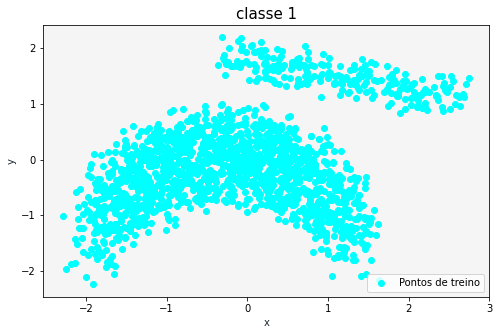

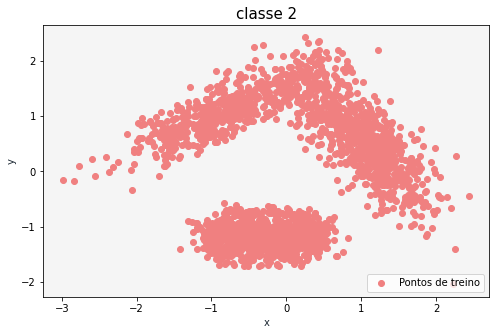

[((-1.91, -2.24), 0, 0, 0), ((1.63, -2.16), 1, 0, 0), ((1.63, -2.16), 0, 1, 0), ((2.69, 1.12), 1, 1, 0), ((2.69, 1.12), 0, 2, 0), ((2.75, 1.47), 1, 2, 0), ((0.713, 2.04), 0, 3, 0), ((2.75, 1.47), 1, 3, 0), ((-0.0814, 2.18), 0, 4, 0), ((0.713, 2.04), 1, 4, 0), ((-0.308, 2.19), 0, 5, 0), ((-0.0814, 2.18), 1, 5, 0), ((-1.9, 0.106), 0, 6, 0), ((-0.308, 2.19), 1, 6, 0), ((-2.28, -1.02), 0, 7, 0), ((-1.9, 0.106), 1, 7, 0), ((-2.28, -1.02), 0, 8, 0), ((-2.25, -1.96), 1, 8, 0), ((-2.25, -1.96), 0, 9, 0), ((-1.91, -2.24), 1, 9, 0), ((2.22, -2.04), 0, 0, 1), ((2.44, -0.448), 1, 0, 1), ((2.27, 0.284), 0, 1, 1), ((2.44, -0.448), 1, 1, 1), ((1.23, 2.19), 0, 2, 1), ((2.27, 0.284), 1, 2, 1), ((0.254, 2.42), 0, 3, 1), ((1.23, 2.19), 1, 3, 1), ((-0.306, 2.28), 0, 4, 1), ((0.254, 2.42), 1, 4, 1), ((-0.434, 2.24), 0, 5, 1), ((-0.306, 2.28), 1, 5, 1), ((-1.29, 1.52), 0, 6, 1), ((-0.434, 2.24), 1, 6, 1), ((-1.93, 0.96), 0, 7, 1), ((-1.29, 1.52), 1, 7, 1), ((-2.77, 0.0962), 0, 8, 1), ((-1.93, 0.96), 1, 8, 1

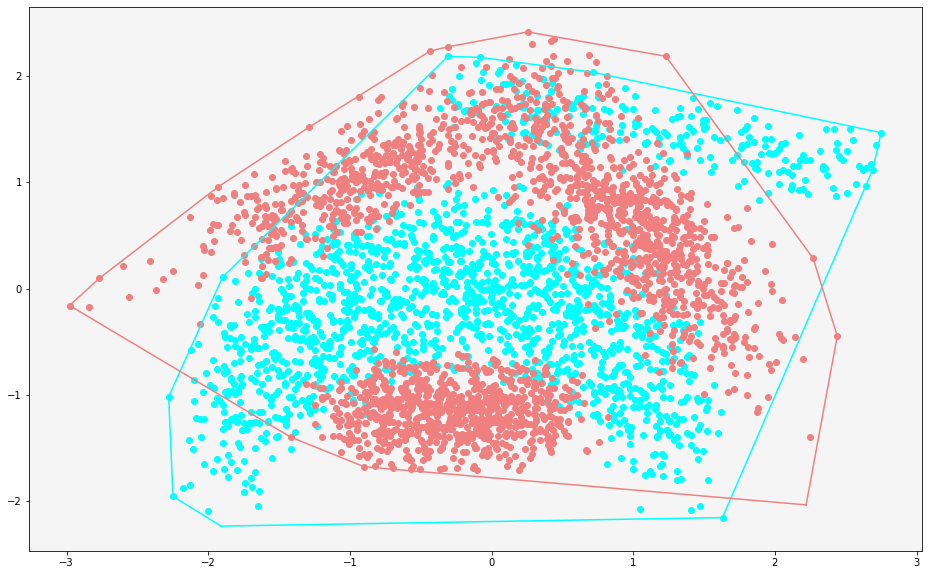

In [ ]:
Experimento(classe1, classe2, 'At1', 'At2', 1, -1)

###Experimento 2: iris 

Esse banco de dadods classifica as plantas de acordo com suas iris entre Iris-setosa, Iris-versicolor, Iris-virginica.

> Usaremos as classes Iris-setosa e Iris-versicolor e, como x e y, utilizaremos os atributos SepalLength e PetalLength.

In [ ]:
BaseIris = pd.read_csv('./iris.csv', delimiter=',')
classe1 = BaseIris[BaseIris['Class'] == ' Iris-setosa']
classe2 = BaseIris[BaseIris['Class'] == ' Iris-versicolor']
BaseIris.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


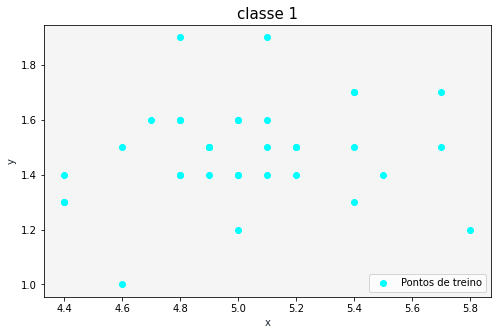

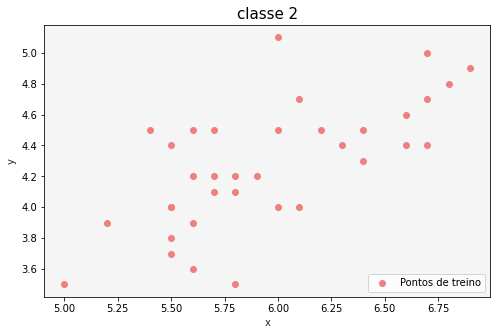

[((4.6, 1.0), 0, 0, 0), ((5.8, 1.2), 1, 0, 0), ((5.7, 1.7), 0, 1, 0), ((5.8, 1.2), 1, 1, 0), ((5.1, 1.9), 0, 2, 0), ((5.7, 1.7), 1, 2, 0), ((4.8, 1.9), 0, 3, 0), ((5.1, 1.9), 1, 3, 0), ((4.4, 1.4), 0, 4, 0), ((4.8, 1.9), 1, 4, 0), ((4.4, 1.3), 0, 5, 0), ((4.4, 1.4), 1, 5, 0), ((4.4, 1.3), 0, 6, 0), ((4.6, 1.0), 1, 6, 0), ((5.0, 3.5), 0, 0, 1), ((5.8, 3.5), 1, 0, 1), ((5.8, 3.5), 0, 1, 1), ((6.7, 4.4), 1, 1, 1), ((6.7, 4.4), 0, 2, 1), ((6.9, 4.9), 1, 2, 1), ((6.7, 5.0), 0, 3, 1), ((6.9, 4.9), 1, 3, 1), ((6.0, 5.1), 0, 4, 1), ((6.7, 5.0), 1, 4, 1), ((5.4, 4.5), 0, 5, 1), ((6.0, 5.1), 1, 5, 1), ((5.0, 3.5), 0, 6, 1), ((5.4, 4.5), 1, 6, 1)]
Dados são linearmente separáveis.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


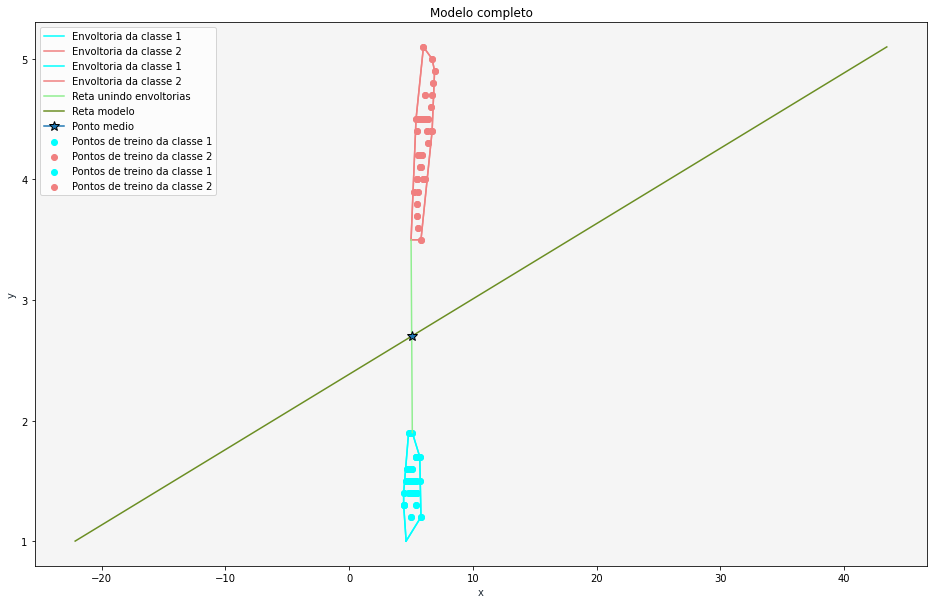

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


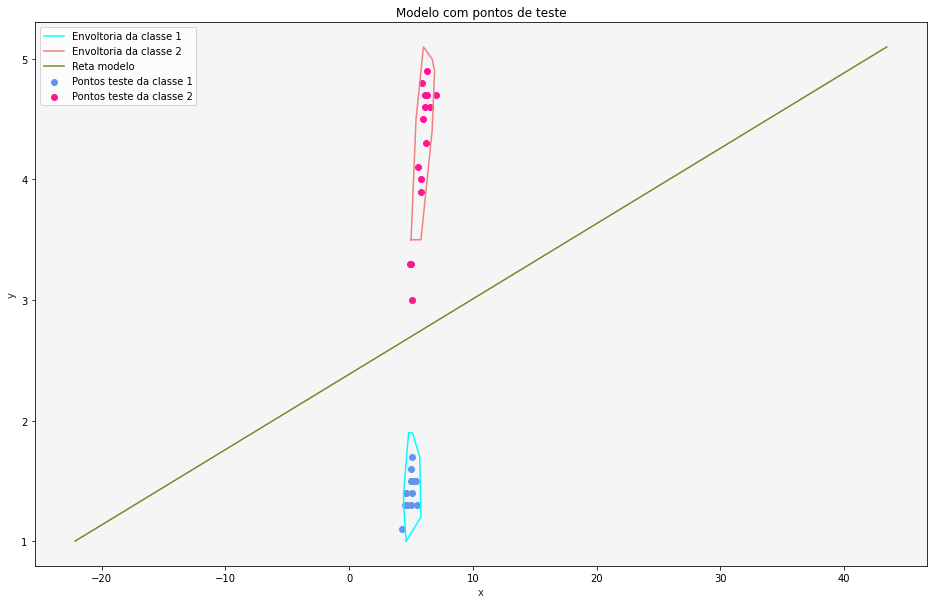

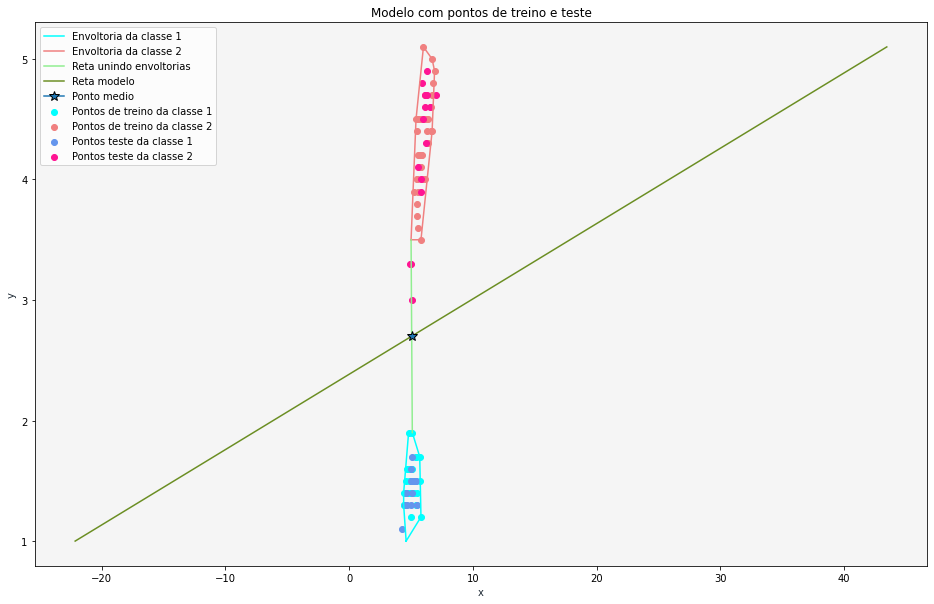

Metricas: 
Precisão:  [1. 1.]
Revocação:  [1. 1.]
F1 score:  [1. 1.]


In [ ]:
Experimento(classe1, classe2, 'SepalLength', 'PetalLength', 'Iris-setosa', 'Iris-versicolor')

###Experimento 3: vidro

O banco de dados classifica vidro entre 6 tipos de acordo com seus componentente (Na, Fe, K, etc.)

> Usaremos as classes 1 e 7 e, como x e y, utilizaremos os atributos RI e K.

In [ ]:
BaseGlass = pd.read_csv('./glass.csv', delimiter=',')
classe1 = BaseGlass[BaseGlass['Class'] == 1]
classe2 = BaseGlass[BaseGlass['Class'] == 7]
BaseGlass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Class
0,1.515888,12.87795,3.43036,1.40066,73.2820,0.68931,8.04468,0.0,0.1224,1
1,1.517642,12.97770,3.53812,1.21127,73.0020,0.65205,8.52888,0.0,0.0000,1
2,1.522130,14.20795,3.82099,0.46976,71.7700,0.11178,9.57260,0.0,0.0000,1
3,1.522221,13.21045,3.77160,0.79076,71.9884,0.13041,10.24520,0.0,0.0000,1
4,1.517551,13.39000,3.65935,1.18880,72.7892,0.57132,8.27064,0.0,0.0561,1


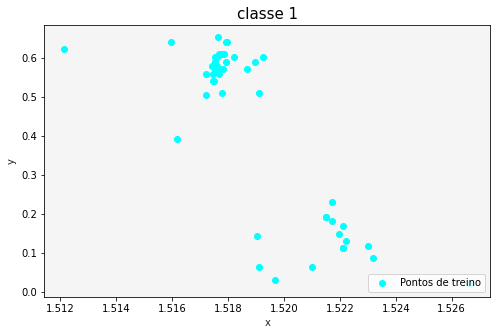

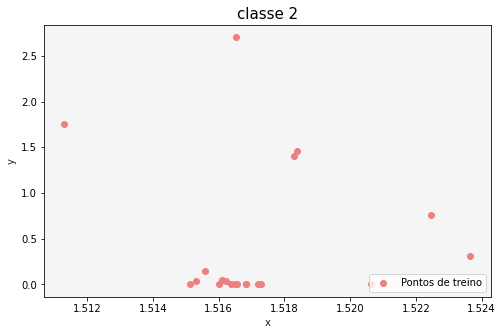

[((1.51925968, 0.60237), 0, 0, 0), ((1.52666318, 0.01863), 1, 0, 0), ((1.5176423, 0.65205), 0, 1, 0), ((1.51925968, 0.60237), 1, 1, 0), ((1.51215232, 0.621), 0, 2, 0), ((1.5176423, 0.65205), 1, 2, 0), ((1.51215232, 0.621), 0, 3, 0), ((1.51910022, 0.0621), 1, 3, 0), ((1.51910022, 0.0621), 0, 4, 0), ((1.51966972, 0.03105), 1, 4, 0), ((1.51966972, 0.03105), 0, 5, 0), ((1.52666318, 0.01863), 1, 5, 0), ((1.5151365, 0.0), 0, 0, 1), ((1.52064926, 0.0), 1, 0, 1), ((1.52064926, 0.0), 0, 1, 1), ((1.52365622, 0.3105), 1, 1, 1), ((1.52247166, 0.75762), 0, 2, 1), ((1.52365622, 0.3105), 1, 2, 1), ((1.51652608, 2.70135), 0, 3, 1), ((1.52247166, 0.75762), 1, 3, 1), ((1.51130946, 1.75743), 0, 4, 1), ((1.51652608, 2.70135), 1, 4, 1), ((1.51130946, 1.75743), 0, 5, 1), ((1.5151365, 0.0), 1, 5, 1)]
Dados não são linearmente separáveis.


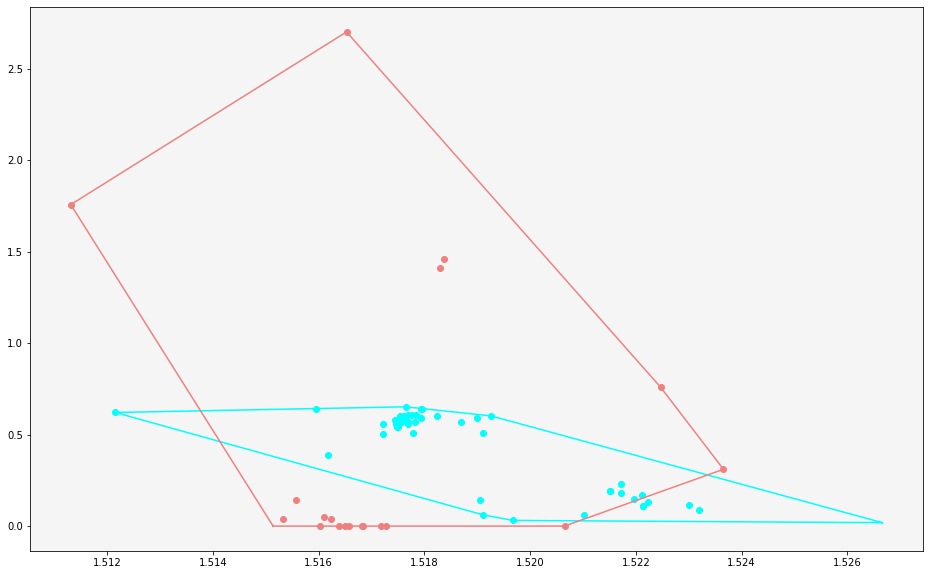

In [ ]:
Experimento(classe1, classe2, 'RI', 'K', 1, 7)

###Experimento 4: shuttle

Contêm 7 atributos numéricos e 7 classes que tipo de a embarcação deve utilizar para o pouso.

> Usaremos as classes 2 e 6 e, como x e y, utilizaremos os atributos A2 e A9.

In [ ]:
BaseShuttle = pd.read_csv('./shuttle.csv', delimiter=',')
classe1 = BaseShuttle[BaseShuttle[' Class'] == 2]
classe2 = BaseShuttle[BaseShuttle[' Class'] == 6]
BaseShuttle.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,Class
0,55,0,92,0,0,26,36,92,56,4
1,53,0,82,0,52,-5,29,30,2,1
2,37,0,76,0,28,18,40,48,8,1
3,37,0,79,0,34,-26,43,46,2,1
4,85,0,88,-4,6,1,3,83,80,5


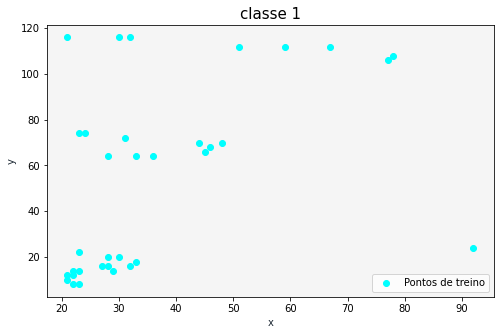

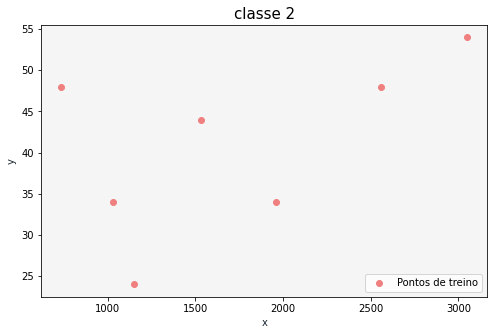

[((22, 8), 0, 0, 0), ((23, 8), 1, 0, 0), ((23, 8), 0, 1, 0), ((92, 24), 1, 1, 0), ((78, 108), 0, 2, 0), ((92, 24), 1, 2, 0), ((67, 112), 0, 3, 0), ((78, 108), 1, 3, 0), ((32, 116), 0, 4, 0), ((67, 112), 1, 4, 0), ((21, 116), 0, 5, 0), ((32, 116), 1, 5, 0), ((21, 10), 0, 6, 0), ((21, 116), 1, 6, 0), ((21, 10), 0, 7, 0), ((22, 8), 1, 7, 0), ((1149, 24), 0, 0, 1), ((1958, 34), 1, 0, 1), ((1958, 34), 0, 1, 1), ((3049, 54), 1, 1, 1), ((736, 48), 0, 2, 1), ((3049, 54), 1, 2, 1), ((736, 48), 0, 3, 1), ((1149, 24), 1, 3, 1)]
Dados são linearmente separáveis.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


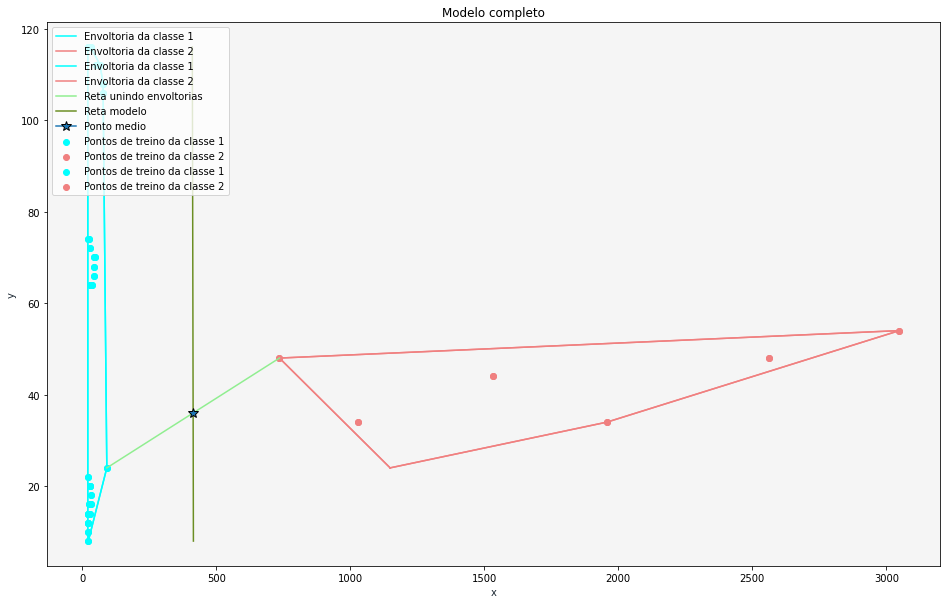

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


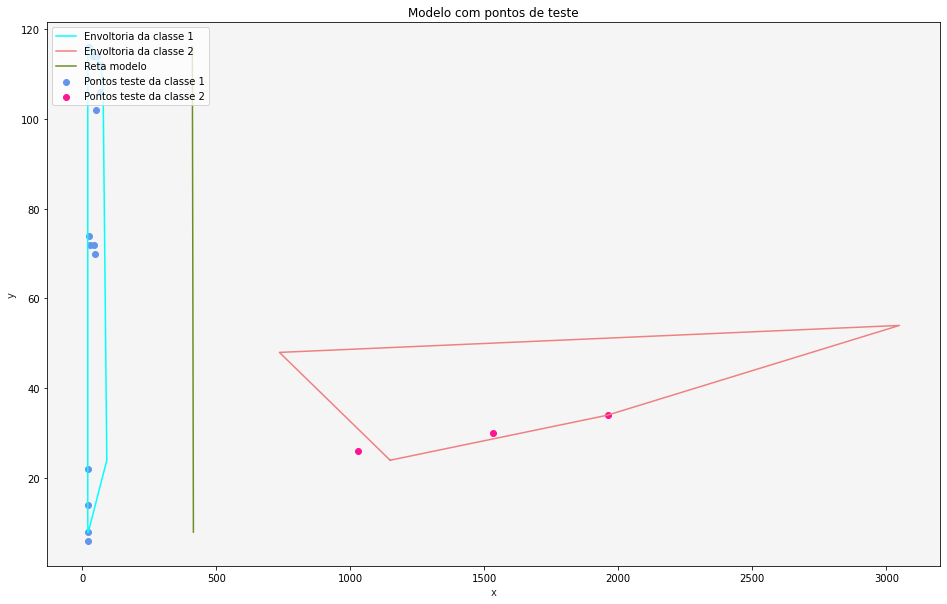

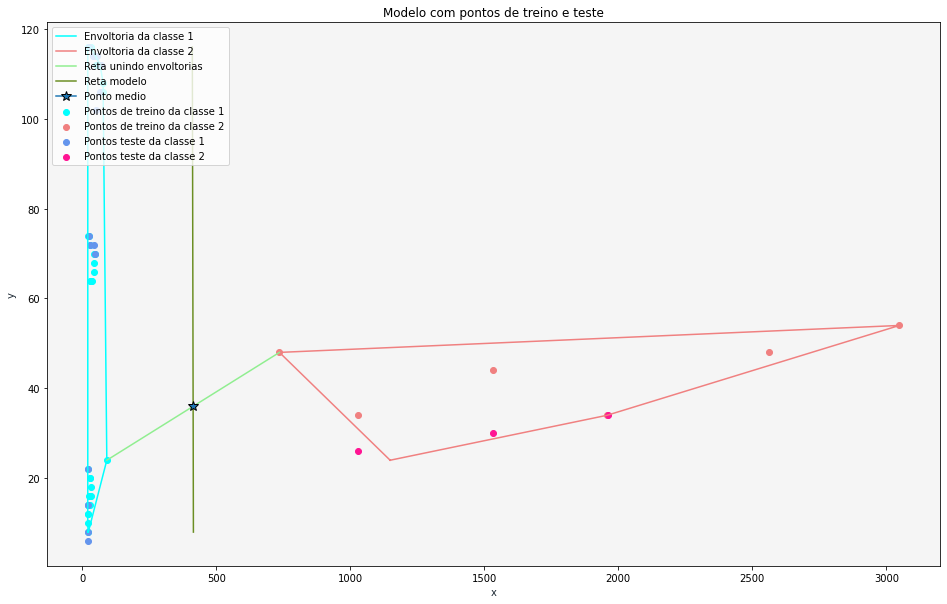

Metricas: 
Precisão:  [1. 1.]
Revocação:  [1. 1.]
F1 score:  [1. 1.]


In [ ]:
Experimento(classe1, classe2, ' A2', ' A9', 2, 6)

###Experimento 5: satimage

O banco de dados consiste do valor de pixels em vizinhanças 3x3 de imagens de satélite e a classificação associada ao pixel central de cada vizinhança entre 7 possíveis classes.

> Usaremos as classes 1 e 4 e, como x e y, utilizaremos os atributos Sp11 e Sp27.

In [ ]:
BaseSatimage = pd.read_csv('./satimage.csv', delimiter=',')
classe1 = BaseSatimage[BaseSatimage['Class'] == 1]
classe2 = BaseSatimage[BaseSatimage['Class'] == 4]
BaseSatimage.head()

,Sp11,Sp12,Sp13,Sp14,Sp15,Sp16,Sp17,Sp18,Sp19,Sp21,...,Sp41,Sp42,Sp43,Sp44,Sp45,Sp46,Sp47,Sp48,Sp49,Class
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,3


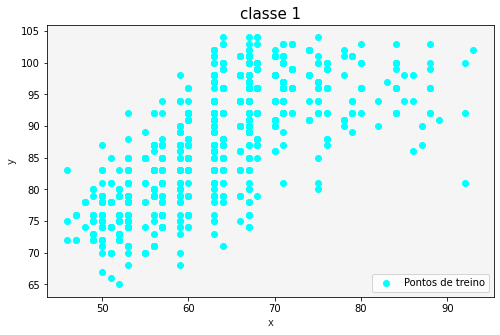

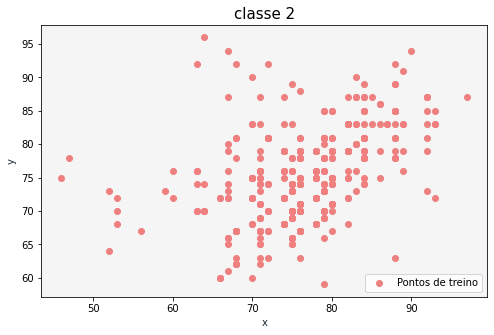

[((52, 65), 0, 0, 0), ((92, 81), 1, 0, 0), ((92, 81), 0, 1, 0), ((93, 102), 1, 1, 0), ((88, 103), 0, 2, 0), ((93, 102), 1, 2, 0), ((75, 104), 0, 3, 0), ((88, 103), 1, 3, 0), ((64, 104), 0, 4, 0), ((75, 104), 1, 4, 0), ((53, 92), 0, 5, 0), ((64, 104), 1, 5, 0), ((46, 83), 0, 6, 0), ((53, 92), 1, 6, 0), ((46, 72), 0, 7, 0), ((46, 83), 1, 7, 0), ((46, 72), 0, 8, 0), ((50, 67), 1, 8, 0), ((50, 67), 0, 9, 0), ((52, 65), 1, 9, 0), ((79, 59), 0, 0, 1), ((88, 63), 1, 0, 1), ((88, 63), 0, 1, 1), ((93, 72), 1, 1, 1), ((93, 72), 0, 2, 1), ((97, 87), 1, 2, 1), ((90, 94), 0, 3, 1), ((97, 87), 1, 3, 1), ((64, 96), 0, 4, 1), ((90, 94), 1, 4, 1), ((47, 78), 0, 5, 1), ((64, 96), 1, 5, 1), ((46, 75), 0, 6, 1), ((47, 78), 1, 6, 1), ((46, 75), 0, 7, 1), ((52, 64), 1, 7, 1), ((52, 64), 0, 8, 1), ((66, 60), 1, 8, 1), ((66, 60), 0, 9, 1), ((79, 59), 1, 9, 1)]
Dados não são linearmente separáveis.


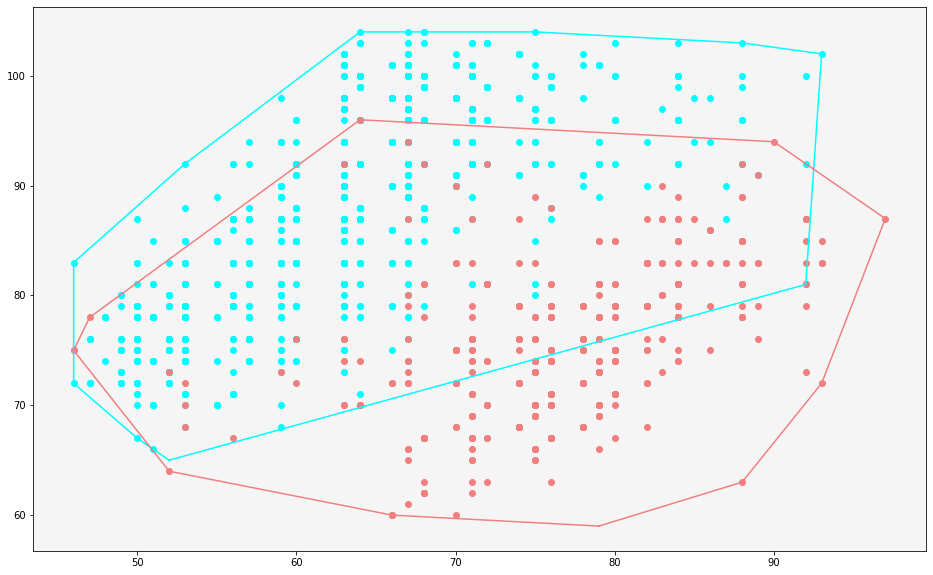

In [ ]:
Experimento(classe1, classe2, 'Sp11', ' Sp27', 1, 4)

###Experimento 6: wine quality

O banco de dados classifica vinhos brancos entre 11 classes sensoriais e usa como atributo dados fisico-químicos.

> Usaremos as classes 4 e 6 e, como x e y, utilizaremos os atributos ResidualSugar e FixedAcidity.

In [ ]:
BaseWinequality_white = pd.read_csv('./winequality-white.csv', delimiter=',')
classe1 = BaseWinequality_white[BaseWinequality_white[' Class'] == 4]
classe2 = BaseWinequality_white[BaseWinequality_white[' Class'] == 6]
BaseWinequality_white.head()

,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,PH,Sulphates,Alcohol,Class
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


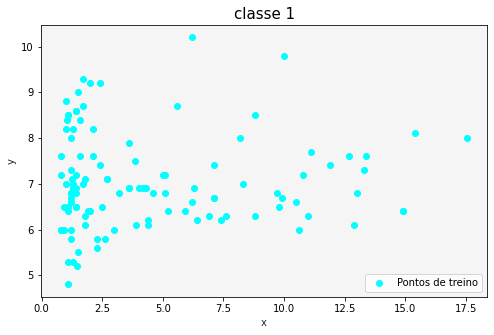

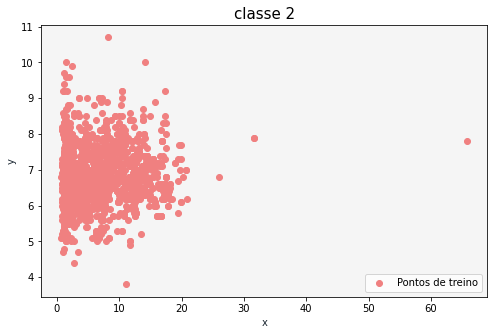

[((1.1, 4.8), 0, 0, 0), ((12.9, 6.1), 1, 0, 0), ((12.9, 6.1), 0, 1, 0), ((14.9, 6.4), 1, 1, 0), ((14.9, 6.4), 0, 2, 0), ((17.55, 8.0), 1, 2, 0), ((10.0, 9.8), 0, 3, 0), ((17.55, 8.0), 1, 3, 0), ((6.2, 10.2), 0, 4, 0), ((10.0, 9.8), 1, 4, 0), ((1.7, 9.3), 0, 5, 0), ((6.2, 10.2), 1, 5, 0), ((1.0, 8.8), 0, 6, 0), ((1.7, 9.3), 1, 6, 0), ((0.8, 7.6), 0, 7, 0), ((1.0, 8.8), 1, 7, 0), ((0.8, 6.0), 0, 8, 0), ((0.8, 7.6), 1, 8, 0), ((0.8, 6.0), 0, 9, 0), ((1.1, 4.8), 1, 9, 0), ((11.1, 3.8), 0, 0, 1), ((65.8, 7.8), 1, 0, 1), ((8.2, 10.7), 0, 1, 1), ((65.8, 7.8), 1, 1, 1), ((1.4, 10.0), 0, 2, 1), ((8.2, 10.7), 1, 2, 1), ((1.2, 9.7), 0, 3, 1), ((1.4, 10.0), 1, 3, 1), ((1.0, 9.2), 0, 4, 1), ((1.2, 9.7), 1, 4, 1), ((0.7, 6.8), 0, 5, 1), ((1.0, 9.2), 1, 5, 1), ((0.7, 5.1), 0, 6, 1), ((0.7, 6.8), 1, 6, 1), ((0.7, 5.1), 0, 7, 1), ((1.0, 4.7), 1, 7, 1), ((1.0, 4.7), 0, 8, 1), ((2.8, 4.4), 1, 8, 1), ((2.8, 4.4), 0, 9, 1), ((11.1, 3.8), 1, 9, 1)]
Dados são linearmente separáveis.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


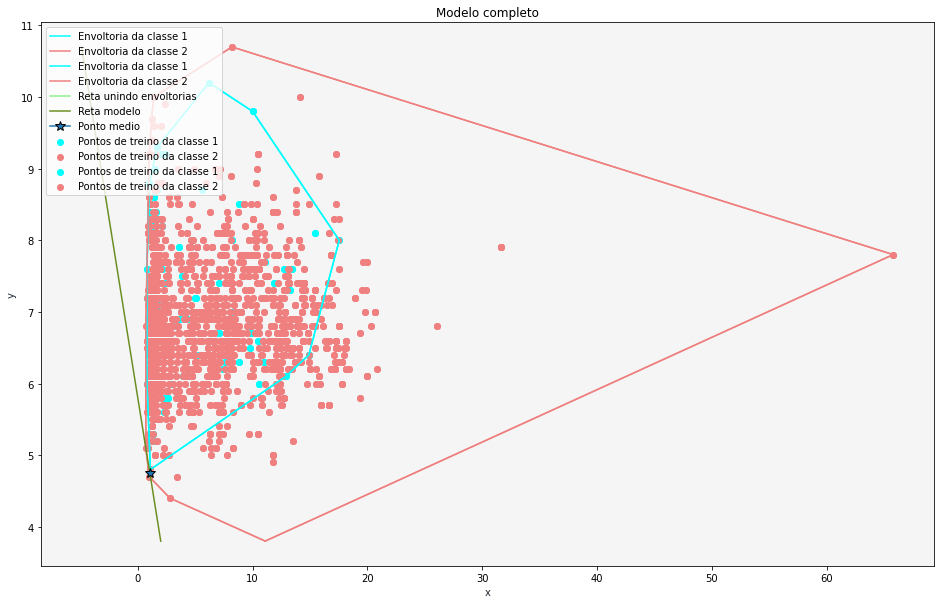

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


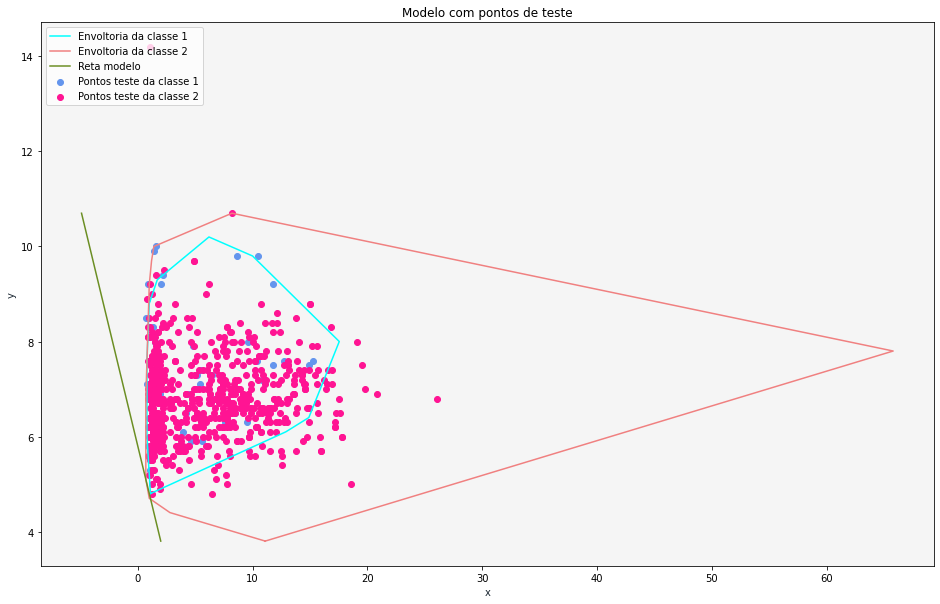

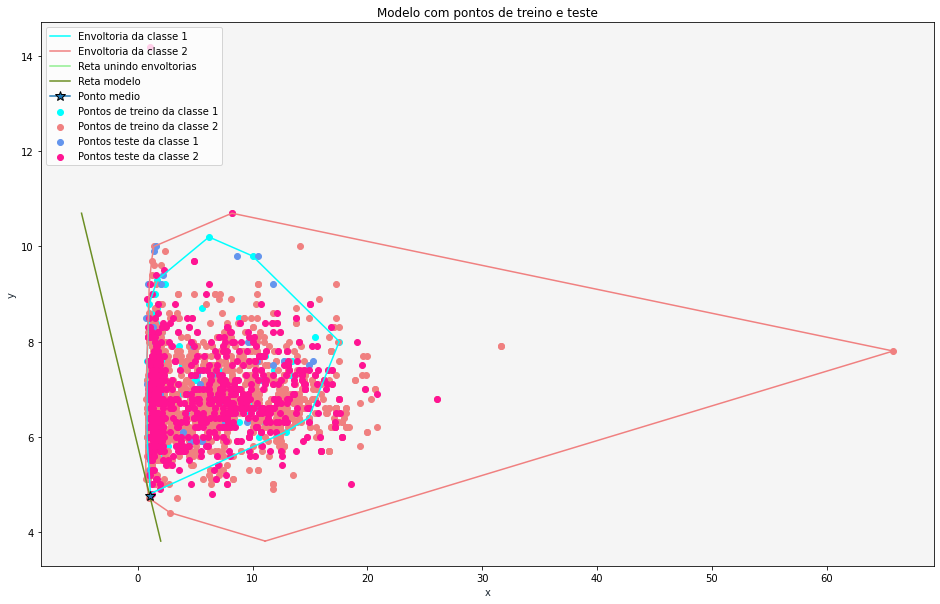

Metricas: 
Precisão:  [1. 0.]
Revocação:  [0.06911142 0.        ]
F1 score:  [0.1292876 0.       ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Experimento(classe1, classe2, ' ResidualSugar', 'FixedAcidity', 4, 6)

###Experimento 7: abalone

O banco de dados busca prever a idade de um abalone(molusco) de acordo com suas caracteristicas físicas. A idade de um abalone é determinada de acordo com a quantidade de anéis em sua concha. 

> Usaremos as classes 4 e 14 e, como x e y, utilizaremos os atributos Diameter e Height.

In [ ]:
BaseAbalone = pd.read_csv('./abalone.csv', delimiter=',')
classe1 = BaseAbalone[BaseAbalone['Class'] == 4]
classe2 = BaseAbalone[BaseAbalone['Class'] == 14]
BaseAbalone.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Class
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


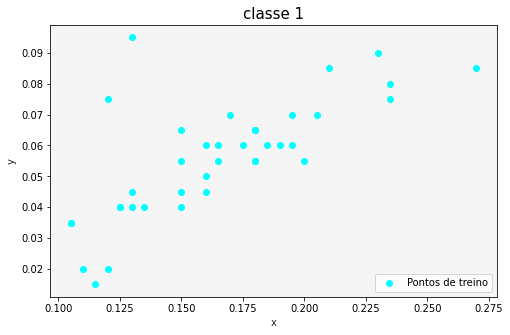

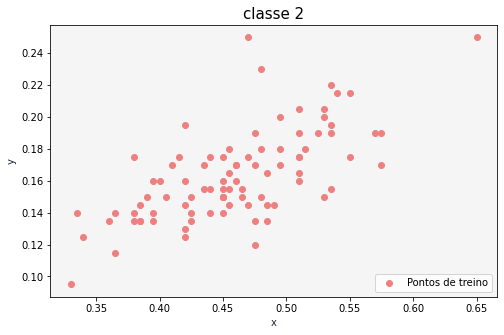

[((0.115, 0.015), 0, 0, 0), ((0.27, 0.085), 1, 0, 0), ((0.23, 0.09), 0, 1, 0), ((0.27, 0.085), 1, 1, 0), ((0.13, 0.095), 0, 2, 0), ((0.23, 0.09), 1, 2, 0), ((0.12, 0.075), 0, 3, 0), ((0.13, 0.095), 1, 3, 0), ((0.105, 0.035), 0, 4, 0), ((0.12, 0.075), 1, 4, 0), ((0.105, 0.035), 0, 5, 0), ((0.11, 0.02), 1, 5, 0), ((0.11, 0.02), 0, 6, 0), ((0.115, 0.015), 1, 6, 0), ((0.33, 0.095), 0, 0, 1), ((0.475, 0.12), 1, 0, 1), ((0.475, 0.12), 0, 1, 1), ((0.575, 0.17), 1, 1, 1), ((0.575, 0.17), 0, 2, 1), ((0.65, 0.25), 1, 2, 1), ((0.47, 0.25), 0, 3, 1), ((0.65, 0.25), 1, 3, 1), ((0.335, 0.14), 0, 4, 1), ((0.47, 0.25), 1, 4, 1), ((0.33, 0.095), 0, 5, 1), ((0.335, 0.14), 1, 5, 1)]
Dados são linearmente separáveis.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


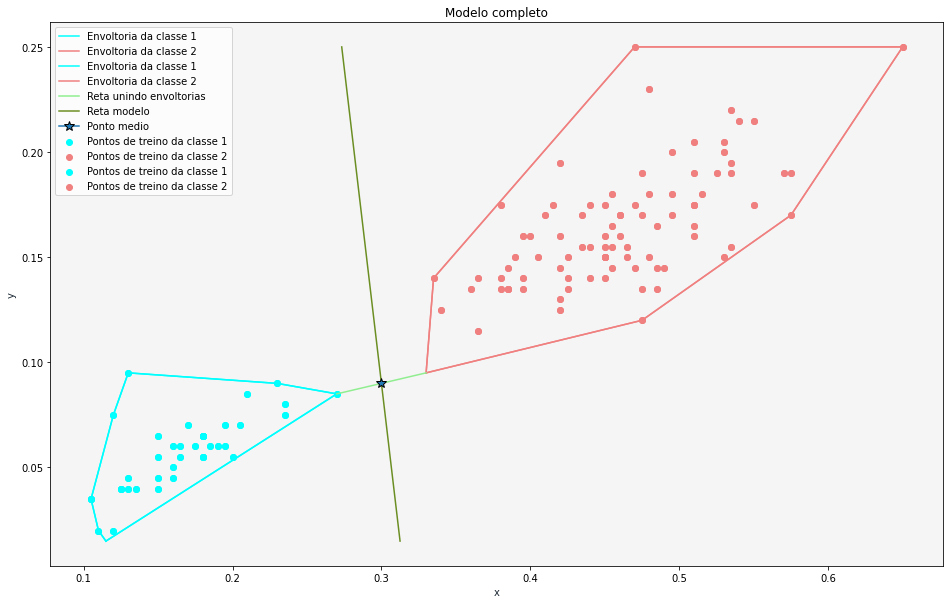

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


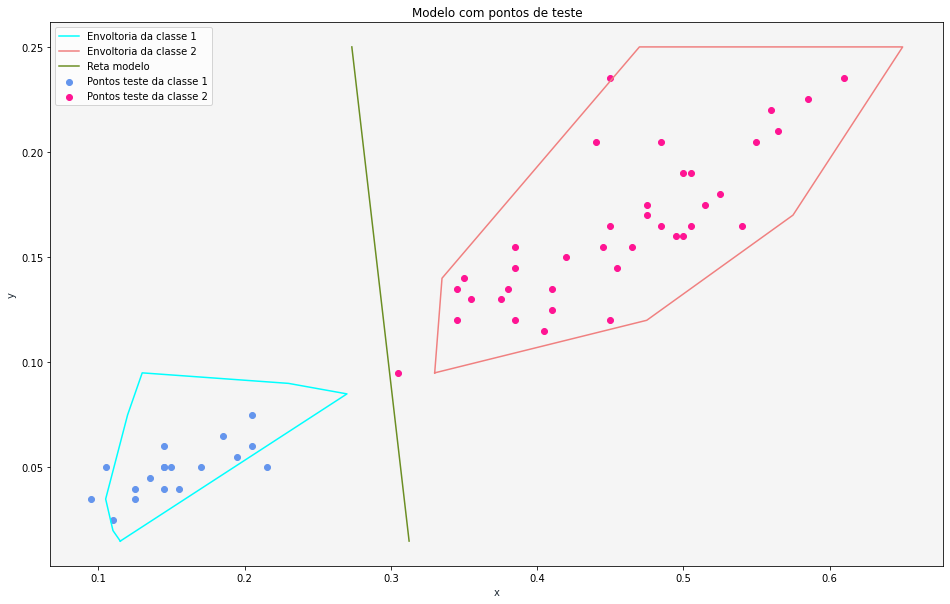

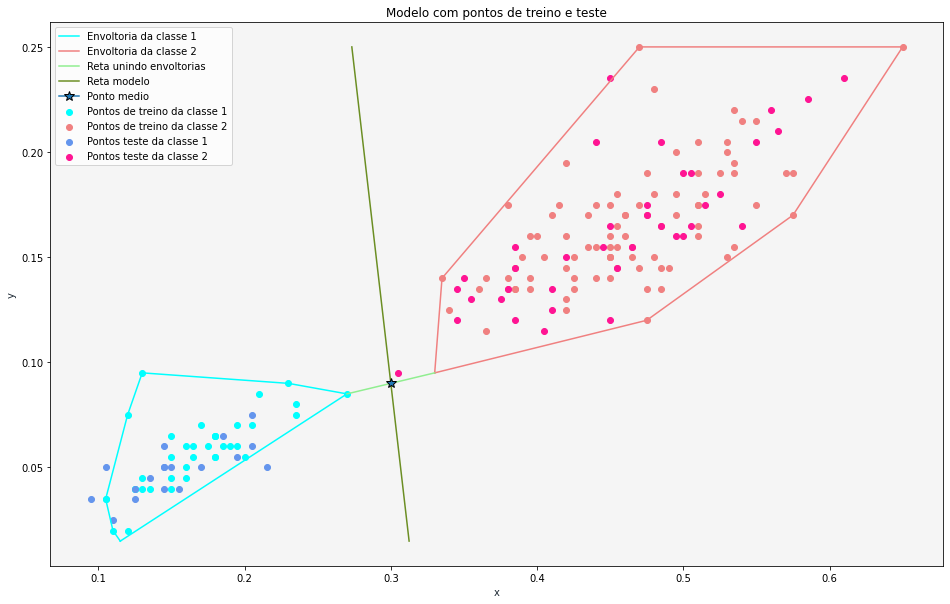

Metricas: 
Precisão:  [1. 1.]
Revocação:  [1. 1.]
F1 score:  [1. 1.]


In [ ]:
Experimento(classe1, classe2, ' Diameter', ' Height', 4, 14)

###Experimento 8: bupa

O banco de dados analisa alguns distúrbios do fígado que podem aumentar com o consumo de álcool. As duas classas servem para decidir os indivíduos que sofrem com alcoolismo.

> Usaremos as classes 1 e 2 e, como x e y, utilizaremos os atributos Mcv e Sgot.

In [ ]:
BaseBupa = pd.read_csv('./bupa.csv', delimiter=',')
classe1 = BaseBupa[BaseBupa[' Class'] == 1]
classe2 = BaseBupa[BaseBupa[' Class'] == 2]
BaseBupa.head()

,Mcv,Alkphos,Sgpt,Sgot,Gammagt,Drinks,Class
0,85.0,92.0,45.0,27.0,31.0,0.0,1
1,85.0,64.0,59.0,32.0,23.0,0.0,2
2,86.0,54.0,33.0,16.0,54.0,0.0,2
3,91.0,78.0,34.0,24.0,36.0,0.0,2
4,98.0,55.0,13.0,17.0,17.0,0.0,2


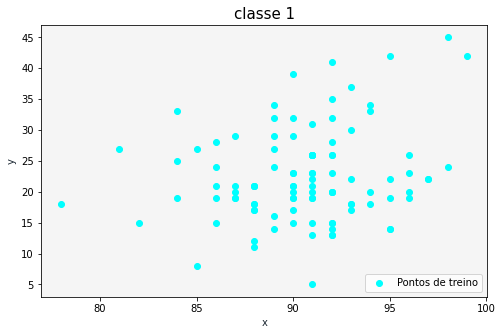

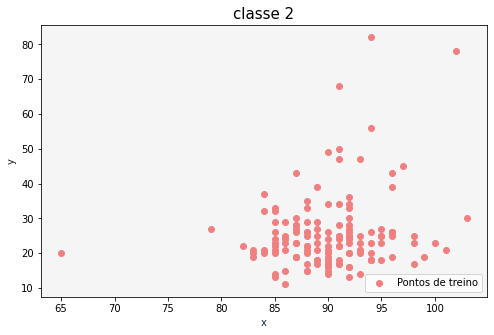

[((91.0, 5.0), 0, 0, 0), ((95.0, 14.0), 1, 0, 0), ((95.0, 14.0), 0, 1, 0), ((98.0, 24.0), 1, 1, 0), ((98.0, 24.0), 0, 2, 0), ((99.0, 42.0), 1, 2, 0), ((98.0, 45.0), 0, 3, 0), ((99.0, 42.0), 1, 3, 0), ((92.0, 41.0), 0, 4, 0), ((98.0, 45.0), 1, 4, 0), ((84.0, 33.0), 0, 5, 0), ((92.0, 41.0), 1, 5, 0), ((81.0, 27.0), 0, 6, 0), ((84.0, 33.0), 1, 6, 0), ((78.0, 18.0), 0, 7, 0), ((81.0, 27.0), 1, 7, 0), ((78.0, 18.0), 0, 8, 0), ((85.0, 8.0), 1, 8, 0), ((85.0, 8.0), 0, 9, 0), ((91.0, 5.0), 1, 9, 0), ((86.0, 11.0), 0, 0, 1), ((92.0, 13.0), 1, 0, 1), ((92.0, 13.0), 0, 1, 1), ((98.0, 17.0), 1, 1, 1), ((98.0, 17.0), 0, 2, 1), ((101.0, 21.0), 1, 2, 1), ((101.0, 21.0), 0, 3, 1), ((103.0, 30.0), 1, 3, 1), ((102.0, 78.0), 0, 4, 1), ((103.0, 30.0), 1, 4, 1), ((94.0, 82.0), 0, 5, 1), ((102.0, 78.0), 1, 5, 1), ((65.0, 20.0), 0, 6, 1), ((94.0, 82.0), 1, 6, 1), ((65.0, 20.0), 0, 7, 1), ((86.0, 11.0), 1, 7, 1)]
Dados não são linearmente separáveis.


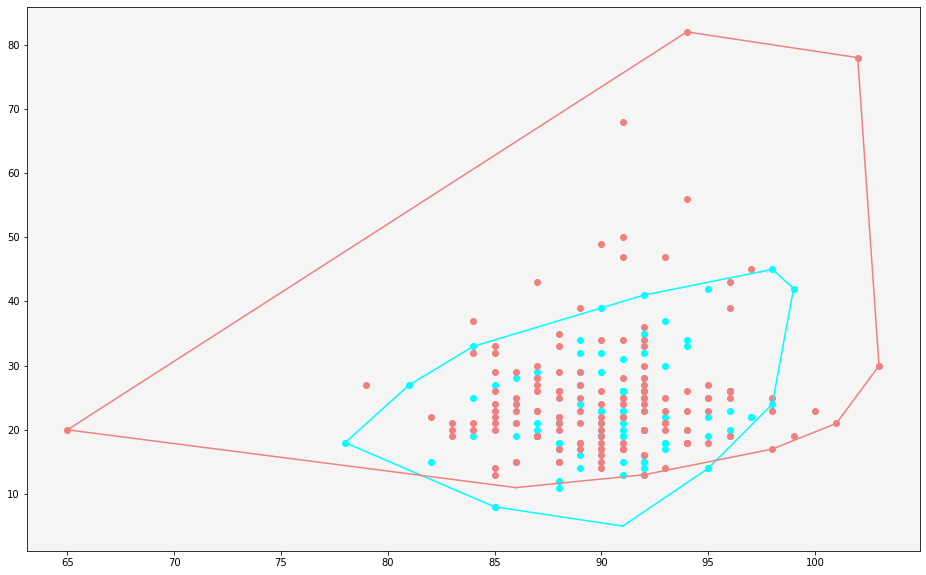

In [ ]:
Experimento(classe1, classe2, 'Mcv', ' Sgot', 1, 2)

###Experimento 9: phoneme

O banco de dados cassifica os fonemas entre sons nasais e sons orais.

> Usaremos as classes 0 e 1 e, como x e y, utilizaremos os atributos Aa e Sh.

In [ ]:
BasePhoneme = pd.read_csv('./phoneme.csv', delimiter=',')
classe1 = BasePhoneme[BasePhoneme[' Class'] == 0]
classe2 = BasePhoneme[BasePhoneme[' Class'] == 1]
BasePhoneme.head()

,Aa,Ao,Dcl,Iy,Sh,Class
0,1.240,0.875,-0.205,-0.078,0.067,0
1,0.268,1.352,1.035,-0.332,0.217,0
2,1.567,0.867,1.300,1.041,0.559,0
3,0.279,0.990,2.555,-0.738,0.000,0
4,0.307,1.272,2.656,-0.946,-0.467,0


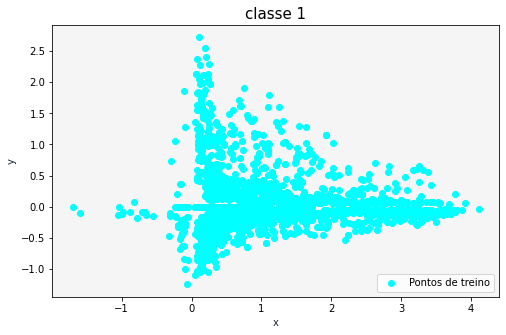

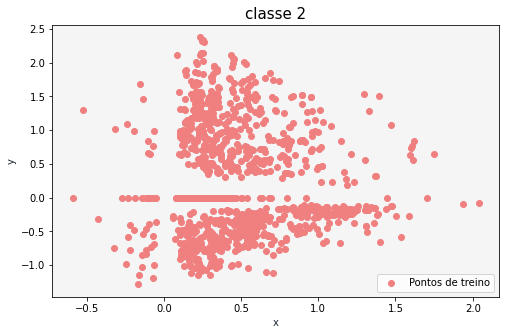

[((-0.059, -1.246), 0, 0, 0), ((3.496, -0.239), 1, 0, 0), ((3.496, -0.239), 0, 1, 0), ((4.107, -0.033), 1, 1, 0), ((3.381, 0.565), 0, 2, 0), ((4.107, -0.033), 1, 2, 0), ((3.258, 0.648), 0, 3, 0), ((3.381, 0.565), 1, 3, 0), ((0.102, 2.719), 0, 4, 0), ((3.258, 0.648), 1, 4, 0), ((-1.7, 0.0), 0, 5, 0), ((0.102, 2.719), 1, 5, 0), ((-1.7, 0.0), 0, 6, 0), ((-1.595, -0.092), 1, 6, 0), ((-1.595, -0.092), 0, 7, 0), ((-0.059, -1.246), 1, 7, 0), ((-0.165, -1.284), 0, 0, 1), ((0.704, -1.12), 1, 0, 1), ((0.704, -1.12), 0, 1, 1), ((1.533, -0.578), 1, 1, 1), ((1.533, -0.578), 0, 2, 1), ((2.038, -0.083), 1, 2, 1), ((1.752, 0.648), 0, 3, 1), ((2.038, -0.083), 1, 3, 1), ((1.396, 1.499), 0, 4, 1), ((1.752, 0.648), 1, 4, 1), ((0.234, 2.373), 0, 5, 1), ((1.396, 1.499), 1, 5, 1), ((-0.523, 1.304), 0, 6, 1), ((0.234, 2.373), 1, 6, 1), ((-0.59, 0.0), 0, 7, 1), ((-0.523, 1.304), 1, 7, 1), ((-0.59, 0.0), 0, 8, 1), ((-0.165, -1.284), 1, 8, 1)]
Dados não são linearmente separáveis.


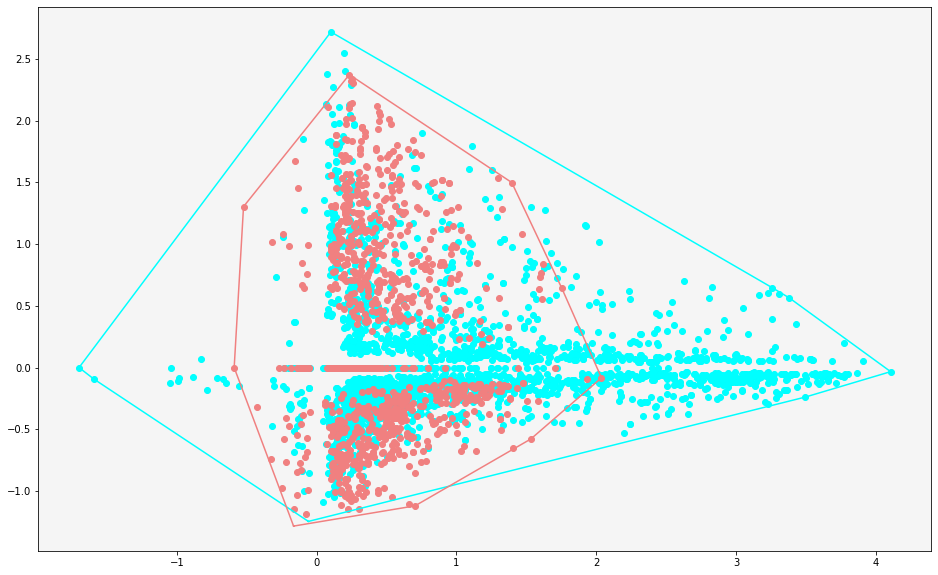

In [ ]:
Experimento(classe1, classe2, 'Aa', ' Sh', 0, 1)

###Experimento 10: texture

O banco de dados classifica 11 tipos de textura diferentes, contem 40 atributos que caracterizam os pixels das texturas.



> Usaremos as classes 12 e 14 e, como x e y, utilizaremos os atributos 1 e 40.



In [ ]:
BaseBands = pd.read_csv('./texture.csv', delimiter=',')
classe1 = BaseBands[BaseBands['Class'] == 12]
classe2 = BaseBands[BaseBands['Class'] == 14]
BaseBands.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A32,A33,A34,A35,A36,A37,A38,A39,A40,Class
0,-1.223,-0.798,-0.867,-0.639,-0.545,-0.412,-0.795,-0.629,-0.547,-0.868,...,-0.766,-0.555,-0.714,-0.545,-0.587,-0.871,-0.620,-0.568,-0.607,2
1,-1.410,-1.029,-1.013,-0.895,-0.762,-0.676,-1.043,-0.851,-0.775,-1.037,...,-0.919,-0.770,-0.847,-0.663,-0.723,-1.013,-0.748,-0.698,-0.817,2
2,-1.107,-0.649,-0.629,-0.492,-0.367,-0.298,-0.682,-0.478,-0.395,-0.681,...,-0.692,-0.445,-0.588,-0.371,-0.368,-0.746,-0.457,-0.379,-0.469,2
3,-1.270,-0.855,-0.958,-0.707,-0.619,-0.469,-0.872,-0.705,-0.620,-0.988,...,-0.829,-0.719,-0.774,-0.617,-0.688,-0.937,-0.693,-0.657,-0.779,2
4,-1.331,-0.862,-0.761,-0.689,-0.498,-0.361,-0.857,-0.600,-0.496,-0.779,...,-0.861,-0.571,-0.784,-0.545,-0.562,-0.952,-0.642,-0.578,-0.648,2


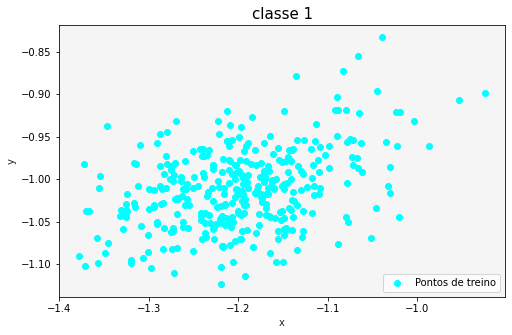

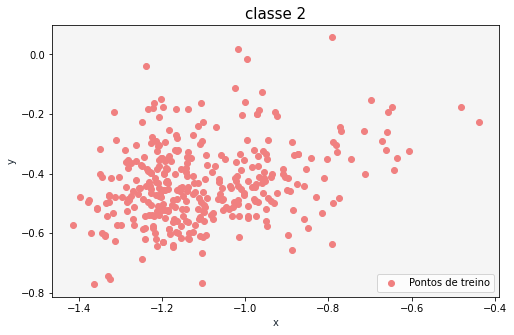

[((-1.219, -1.124), 0, 0, 0), ((-1.052, -1.069), 1, 0, 0), ((-1.052, -1.069), 0, 1, 0), ((-1.02, -1.045), 1, 1, 0), ((-1.02, -1.045), 0, 2, 0), ((-0.924, -0.899), 1, 2, 0), ((-1.039, -0.833), 0, 3, 0), ((-0.924, -0.899), 1, 3, 0), ((-1.347, -0.937), 0, 4, 0), ((-1.039, -0.833), 1, 4, 0), ((-1.372, -0.982), 0, 5, 0), ((-1.347, -0.937), 1, 5, 0), ((-1.378, -1.091), 0, 6, 0), ((-1.372, -0.982), 1, 6, 0), ((-1.378, -1.091), 0, 7, 0), ((-1.371, -1.102), 1, 7, 0), ((-1.371, -1.102), 0, 8, 0), ((-1.219, -1.124), 1, 8, 0), ((-1.363, -0.772), 0, 0, 1), ((-1.103, -0.766), 1, 0, 1), ((-1.103, -0.766), 0, 1, 1), ((-0.792, -0.636), 1, 1, 1), ((-0.792, -0.636), 0, 2, 1), ((-0.439, -0.227), 1, 2, 1), ((-0.482, -0.175), 0, 3, 1), ((-0.439, -0.227), 1, 3, 1), ((-0.792, 0.057), 0, 4, 1), ((-0.482, -0.175), 1, 4, 1), ((-1.017, 0.018), 0, 5, 1), ((-0.792, 0.057), 1, 5, 1), ((-1.237, -0.038), 0, 6, 1), ((-1.017, 0.018), 1, 6, 1), ((-1.315, -0.194), 0, 7, 1), ((-1.237, -0.038), 1, 7, 1), ((-1.397, -0.479), 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


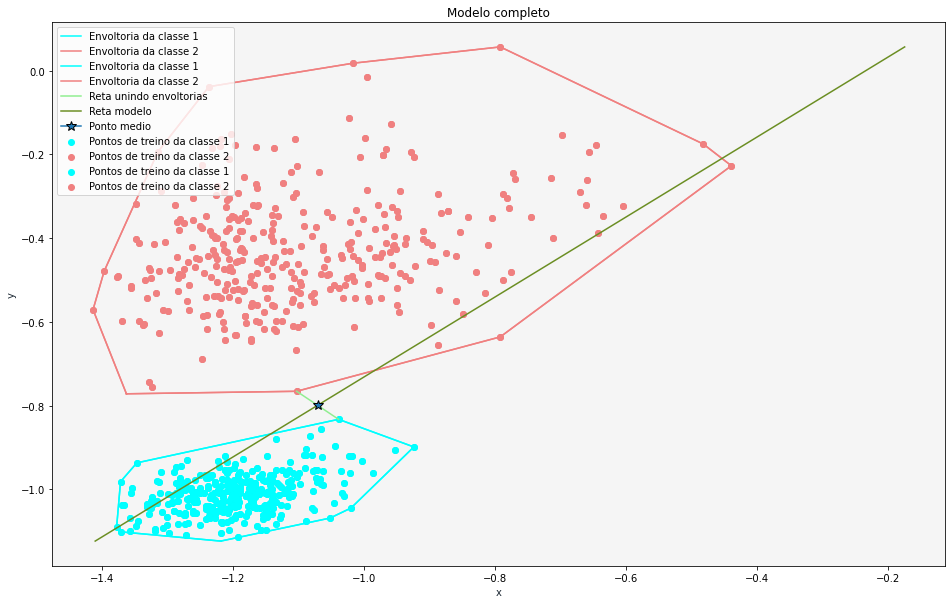

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


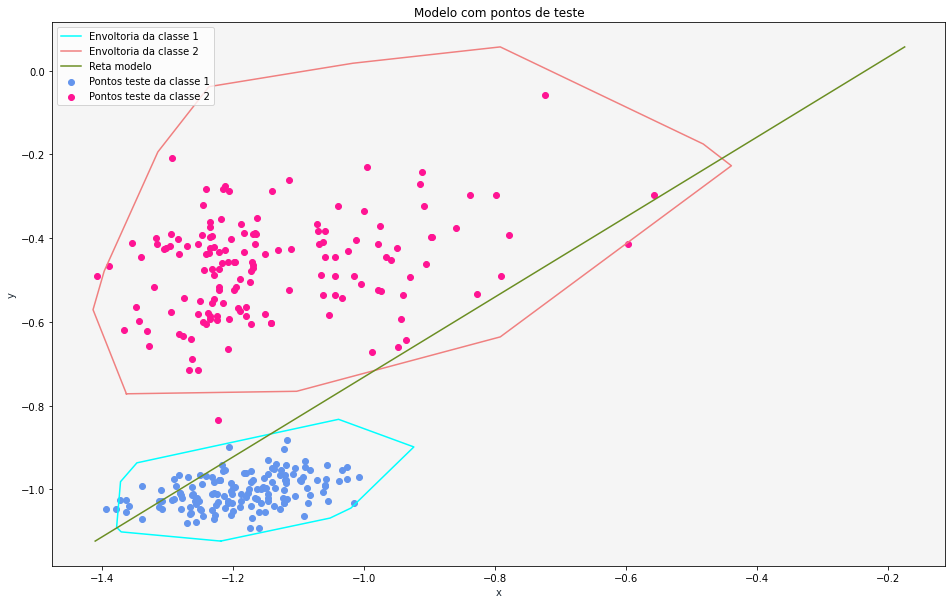

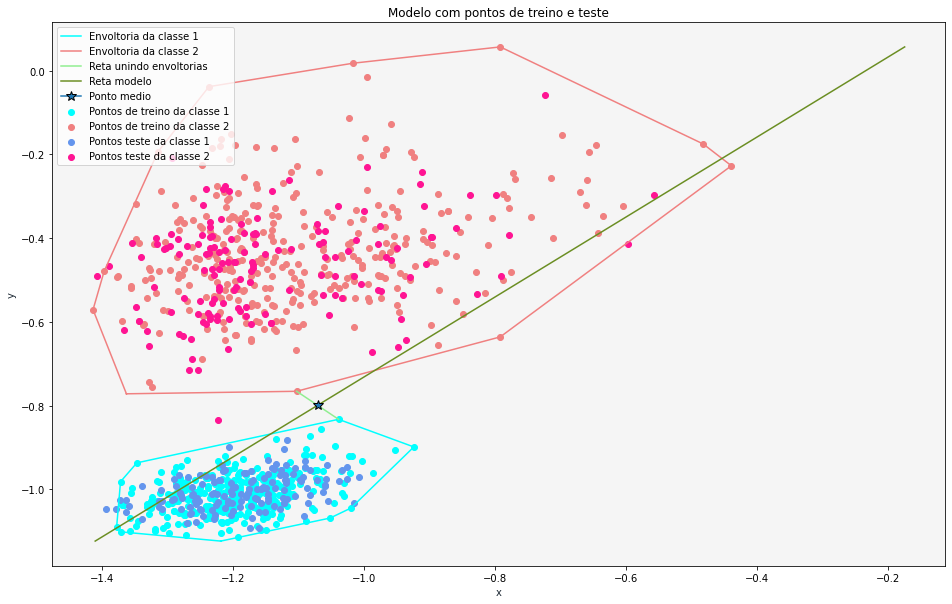

Metricas: 
Precisão:  [0.9        0.99333333]
Revocação:  [0.99264706 0.90853659]
F1 score:  [0.94405594 0.94904459]


In [ ]:
Experimento(classe1, classe2, 'A1', ' A40', 12, 14)

###Experimento 11: movement libras

O banco de dados contem 15 classes que referenciam os tipos de movimentos com as mãos em Libras. Cada classe possui 24 instancias cada.



> Usaremos as classes 5 e 12 e, como x e y, utilizaremos a abscissa da segunda coordenada e a abscissa da vigésima segunda coordenada.



In [ ]:
BaseLibras = pd.read_csv('./movement_libras.csv', delimiter=',')
classe1 = BaseLibras[BaseLibras['Class'] == 5]
classe2 = BaseLibras[BaseLibras['Class'] == 12]
BaseLibras.head()

,1st_coordinate_abcissa,1st_coordinate_ordinate,2st_coordinate_abcissa,2st_coordinate_ordinate,3st_coordinate_abcissa,3st_coordinate_ordinate,4st_coordinate_abcissa,4st_coordinate_ordinate,5st_coordinate_abcissa,5st_coordinate_ordinate,...,41st_coordinate_ordinate,42st_coordinate_abcissa,42st_coordinate_ordinate,43st_coordinate_abcissa,43st_coordinate_ordinate,44st_coordinate_abcissa,44st_coordinate_ordinate,45st_coordinate_abcissa,45st_coordinate_ordinate,Class
0,0.79691,0.38194,0.79691,0.37731,0.79884,0.37731,0.79497,0.37731,0.77563,0.35417,...,0.51389,0.39845,0.42593,0.47389,0.36111,0.55899,0.31250,0.63830,0.29398,1
1,0.67892,0.27315,0.68085,0.27315,0.68085,0.27315,0.68085,0.27315,0.67892,0.26852,...,0.57407,0.17795,0.63657,0.17215,0.67361,0.17021,0.69213,0.17215,0.69213,1
2,0.72147,0.23611,0.72340,0.23611,0.72340,0.23611,0.72340,0.23611,0.72340,0.23611,...,0.30556,0.59768,0.25926,0.67118,0.25231,0.73501,0.26620,0.78143,0.27778,1
3,0.56480,0.32407,0.56286,0.32407,0.56093,0.32407,0.55899,0.32407,0.55899,0.32407,...,0.49074,0.26306,0.42361,0.33269,0.34722,0.41006,0.28009,0.49130,0.24306,1
4,0.67118,0.38426,0.67118,0.38657,0.67311,0.38657,0.67311,0.38426,0.67311,0.37963,...,0.76389,0.44101,0.64120,0.45068,0.54167,0.47776,0.44213,0.53191,0.34259,1


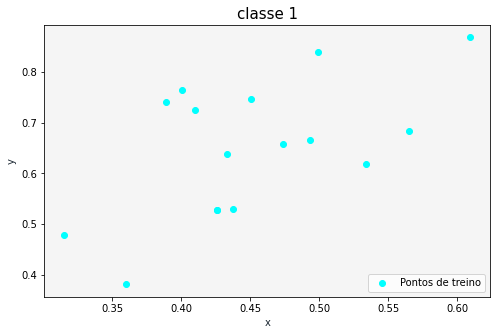

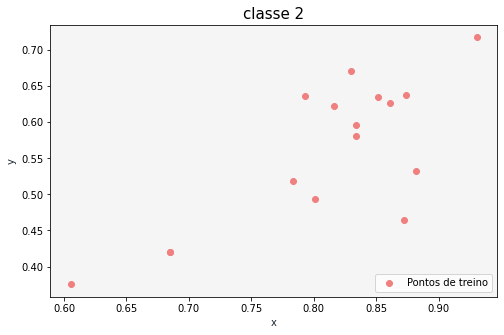

[((0.35977, 0.38104), 0, 0, 0), ((0.53385, 0.61896), 1, 0, 0), ((0.53385, 0.61896), 0, 1, 0), ((0.5648, 0.68472), 1, 1, 0), ((0.5648, 0.68472), 0, 2, 0), ((0.60928, 0.86847), 1, 2, 0), ((0.49903, 0.83946), 0, 3, 0), ((0.60928, 0.86847), 1, 3, 0), ((0.40039, 0.76402), 0, 4, 0), ((0.49903, 0.83946), 1, 4, 0), ((0.38878, 0.74081), 0, 5, 0), ((0.40039, 0.76402), 1, 5, 0), ((0.31528, 0.47776), 0, 6, 0), ((0.38878, 0.74081), 1, 6, 0), ((0.31528, 0.47776), 0, 7, 0), ((0.35977, 0.38104), 1, 7, 0), ((0.60542, 0.37524), 0, 0, 1), ((0.87234, 0.46422), 1, 0, 1), ((0.87234, 0.46422), 0, 1, 1), ((0.93037, 0.7176), 1, 1, 1), ((0.82979, 0.67118), 0, 2, 1), ((0.93037, 0.7176), 1, 2, 1), ((0.79304, 0.63636), 0, 3, 1), ((0.82979, 0.67118), 1, 3, 1), ((0.60542, 0.37524), 0, 4, 1), ((0.79304, 0.63636), 1, 4, 1)]
Dados são linearmente separáveis.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


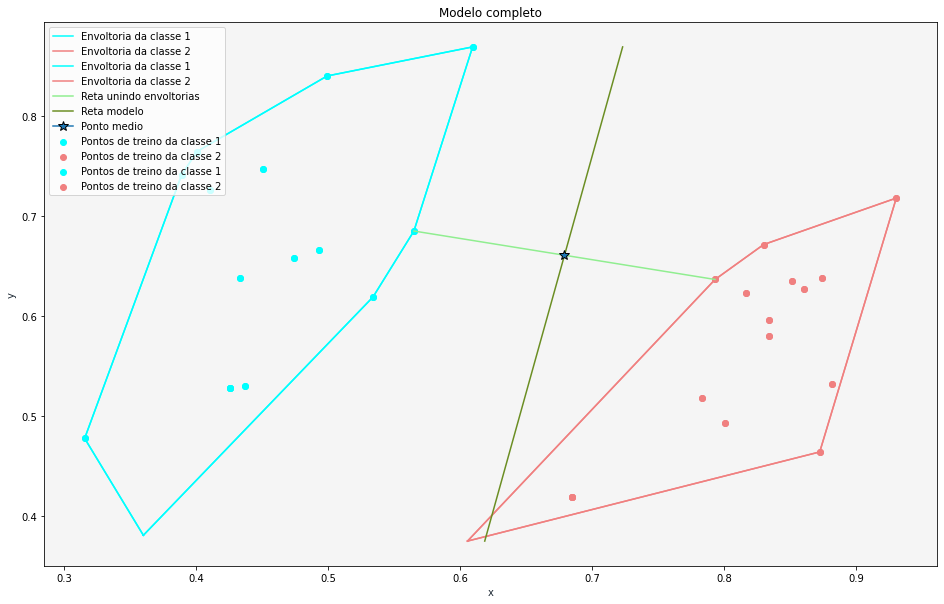

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


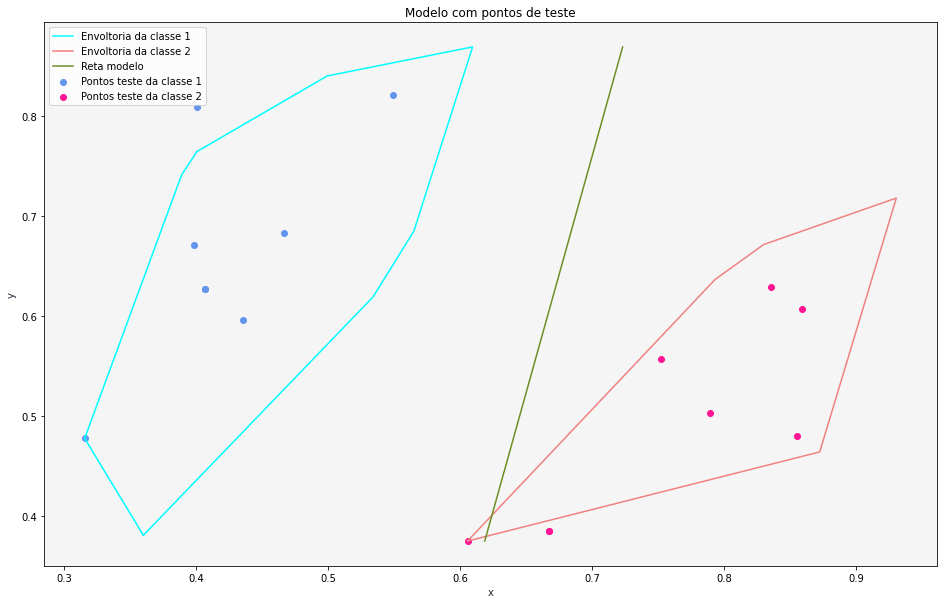

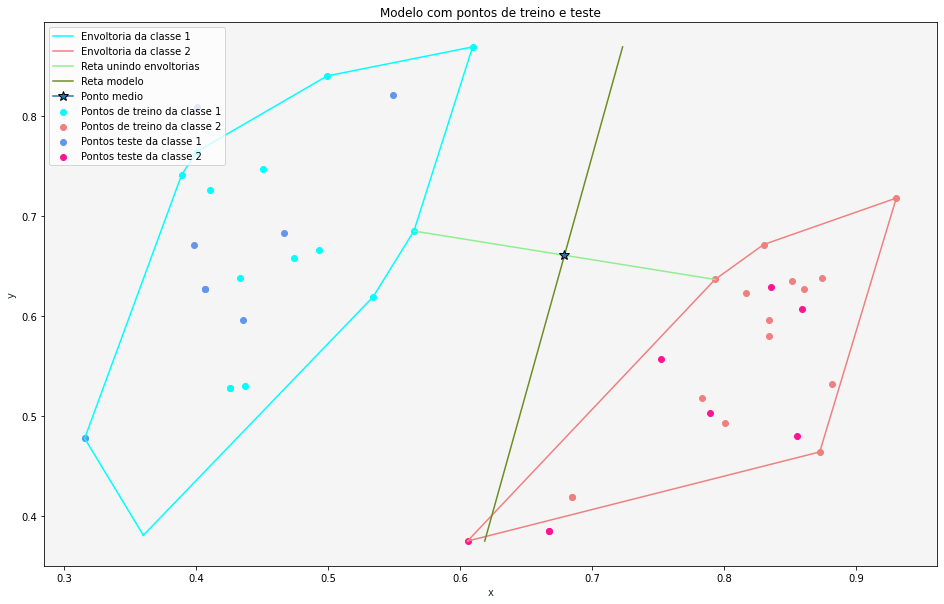

Metricas: 
Precisão:  [1.    0.875]
Revocação:  [0.88888889 1.        ]
F1 score:  [0.94117647 0.93333333]


In [ ]:
Experimento(classe1, classe2, ' 2st_coordinate_abcissa', ' 22st_coordinate_abcissa', 5, 12)

###Experimento 12: segment

O banco de dados tem como objetivo determinar o tipo de superfice de fotos que classifica cada pixel da imagem.



> Usaremos as classes 1 e 6 e, como x e y, utilizaremos Intensity-mean e Hedge-mean.



In [ ]:
BaseSegment = pd.read_csv('./segment.csv', delimiter=',')
classe1 = BaseSegment[BaseSegment['Class'] == 1]
classe2 = BaseSegment[BaseSegment['Class'] == 6]
BaseSegment.head()

,Region-centroid-col,Region-centroid-row,Region-pixel-count,Short-line-density-5,Short-line-density-2,Vedge-mean,Vegde-sd,Hedge-mean,Hedge-sd,Intensity-mean,Rawred-mean,Rawblue-mean,Rawgreen-mean,Exred-mean,Exblue-mean,Exgreen-mean,Value-mean,Saturatoin-mean,Hue-mean,Class
0,218.0,178.0,9.0,0.111111,0.0,0.833333,0.547722,1.111109,0.544331,59.629630,52.444443,75.222220,51.222220,-21.555555,46.777780,-25.222221,75.222220,0.318996,-2.040554,6
1,113.0,130.0,9.0,0.000000,0.0,0.277778,0.250924,0.333333,0.365148,0.888889,0.000000,2.555556,0.111111,-2.666667,5.000000,-2.333333,2.555556,1.000000,-2.123254,3
2,32.0,173.0,9.0,0.000000,0.0,1.722222,1.781593,9.000000,6.749488,43.592594,39.555557,52.888890,38.333336,-12.111111,27.888890,-15.777778,52.888890,0.266914,-1.998857,6
3,61.0,197.0,9.0,0.000000,0.0,1.444444,1.515353,2.611111,1.925463,49.592594,44.222220,61.555557,43.000000,-16.111110,35.888890,-19.777779,61.555557,0.302925,-2.022274,6
4,149.0,185.0,9.0,0.000000,0.0,1.555555,1.068055,3.055555,1.925463,49.333332,45.333332,59.555557,43.111110,-12.000000,30.666666,-18.666666,59.555557,0.275889,-1.952770,6


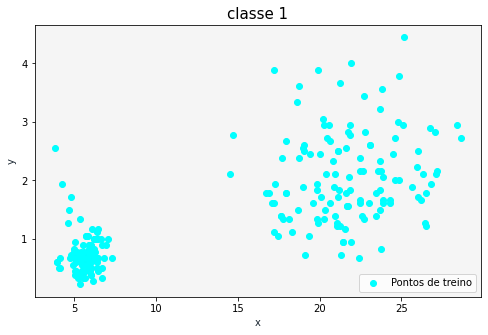

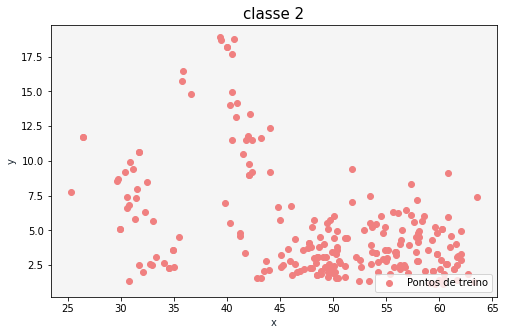

[((5.3703704, 0.22222216), 0, 0, 0), ((22.407408, 0.6666673), 1, 0, 0), ((22.407408, 0.6666673), 0, 1, 0), ((23.74074, 0.8333333), 1, 1, 0), ((23.74074, 0.8333333), 0, 2, 0), ((26.481482, 1.222222), 1, 2, 0), ((26.481482, 1.222222), 0, 3, 0), ((28.62963, 2.7222216), 1, 3, 0), ((28.407408, 2.9444444), 0, 4, 0), ((28.62963, 2.7222216), 1, 4, 0), ((25.185184, 4.4444447), 0, 5, 0), ((28.407408, 2.9444444), 1, 5, 0), ((17.222221, 3.8888884), 0, 6, 0), ((25.185184, 4.4444447), 1, 6, 0), ((3.8148148, 2.5555553), 0, 7, 0), ((17.222221, 3.8888884), 1, 7, 0), ((3.8148148, 2.5555553), 0, 8, 0), ((3.925926, 0.6111111), 1, 8, 0), ((3.925926, 0.6111111), 0, 9, 0), ((4.0740743, 0.50000006), 1, 9, 0), ((4.0740743, 0.50000006), 0, 10, 0), ((5.3703704, 0.22222216), 1, 10, 0), ((59.62963, 1.1111094), 0, 0, 1), ((60.333332, 1.1111113), 1, 0, 1), ((60.333332, 1.1111113), 0, 1, 1), ((63.22222, 1.2777786), 1, 1, 1), ((63.22222, 1.2777786), 0, 2, 1), ((63.51852, 7.3888893), 1, 2, 1), ((60.814816, 9.111109), 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


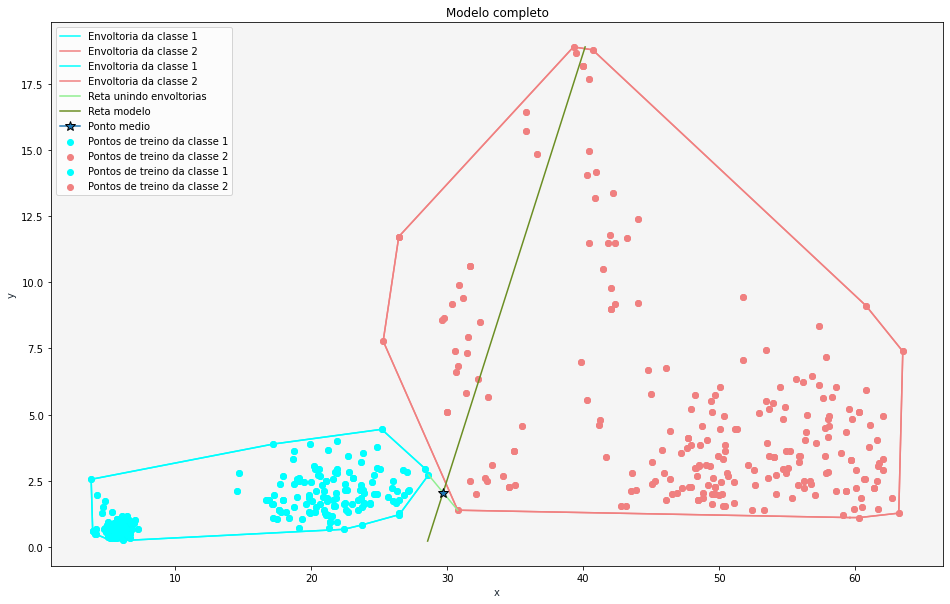

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


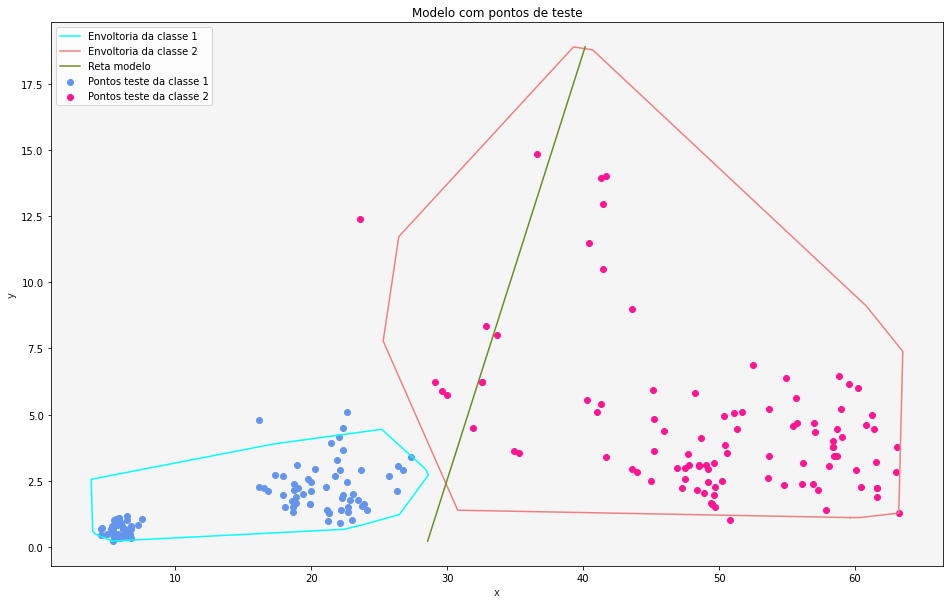

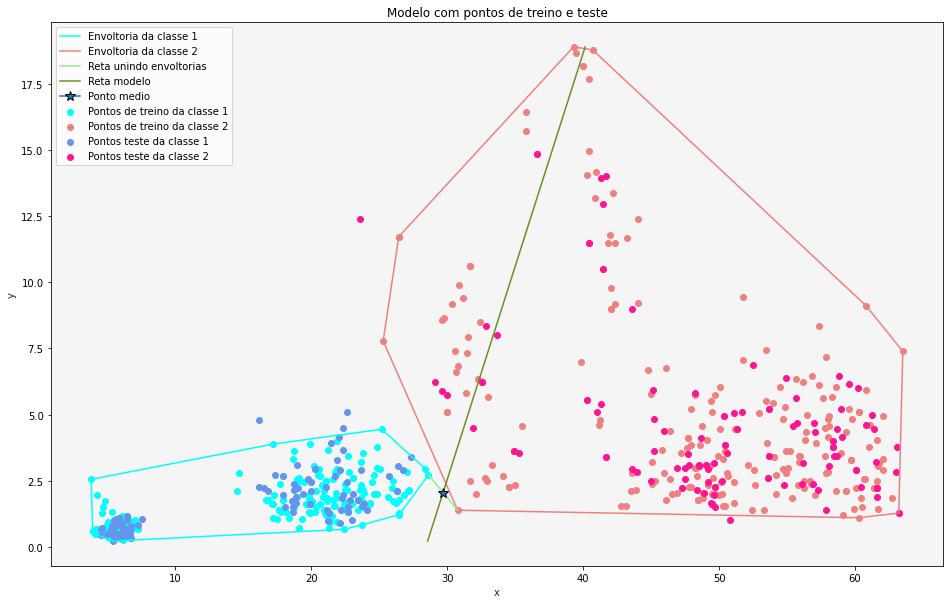

Metricas: 
Precisão:  [1.         0.93939394]
Revocação:  [0.94285714 1.        ]
F1 score:  [0.97058824 0.96875   ]


In [ ]:
Experimento(classe1, classe2, ' Intensity-mean', ' Hedge-mean', 1, 6)